In [1]:
# =============================================================================
# MAIN TRAINING PIPELINE - F2-OPTIMIZED CASCADE MODEL
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (roc_auc_score, f1_score, recall_score, precision_score,
                             accuracy_score, confusion_matrix, fbeta_score)
from tensorflow import keras
from tensorflow.keras import layers, Sequential
import warnings
warnings.filterwarnings('ignore')

print("\n" + "=" * 100)
print("MAIN TRAINING: F2-OPTIMIZED CASCADE MODEL")
print("=" * 100)

# Load dataset
print("\n📂 Loading telecom dataset...\n")
try:
    data = pd.read_csv('/content/sample_data/telecom_customer_churn.csv')
    print(f"✓ Dataset loaded: {data.shape[0]} rows")
except Exception as e:
    print(f"✗ Error: {e}")
    data = None

if data is not None:
    # =============================================================================
    # DATA PREPROCESSING
    # =============================================================================
    print("🔄 Preprocessing data...")

    churn_map = {'Churned': 1, 'Stayed': 0, 'Yes': 1, 'No': 0}
    if 'Churn' in data.columns:
        data['Churn'] = data['Churn'].map(churn_map)

    if 'TenureinMonths' in data.columns:
        data['tenure'] = data['TenureinMonths'].astype(float)
    else:
        data['tenure'] = data['tenure'].astype(float)

    if 'MonthlyCharge' in data.columns:
        data['MonthlyCharges'] = data['MonthlyCharge'].astype(float)
    else:
        data['MonthlyCharges'] = data['MonthlyCharges'].astype(float)

    if 'TotalCharges' in data.columns:
        try:
            data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
            data['TotalCharges'] = data['TotalCharges'].fillna(
                data['tenure'] * data['MonthlyCharges']
            )
        except:
            data['TotalCharges'] = data['tenure'] * data['MonthlyCharges']
    else:
        data['TotalCharges'] = data['tenure'] * data['MonthlyCharges']

    contract_map = {'Month-to-Month': 0, 'One Year': 1, 'Two Year': 2}
    if 'Contract' in data.columns:
        data['Contract'] = data['Contract'].map(contract_map)
    else:
        data['Contract'] = 0

    # Drop NaN
    critical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Contract']
    data = data.dropna(subset=critical_cols)

    print(f"✓ Data preprocessed: {len(data)} rows, Churn rate: {data['Churn'].mean():.2%}")




MAIN TRAINING: F2-OPTIMIZED CASCADE MODEL

📂 Loading telecom dataset...

✓ Dataset loaded: 7043 rows
🔄 Preprocessing data...
✓ Data preprocessed: 6589 rows, Churn rate: 28.37%


In [2]:
# =============================================================================
# PREPROCESSING
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

print("🔄 CORRECTED DATA PREPROCESSING")
print("=" * 80)

def correct_telecom_preprocessing(df):
    """
    Corrected preprocessing that preserves negative values and handles encoding properly
    """
    df_processed = df.copy()

    print("📝 Handling target variable...")
    # 1. Target variable - handle both string and numeric formats
    if 'Churn' in df_processed.columns:
        # Check if Churn is already numeric
        if df_processed['Churn'].dtype in ['int64', 'float64']:
            print("   ✓ Churn is already numeric")
        else:
            churn_map = {'Churned': 1, 'Stayed': 0, 'Joined': 0}
            df_processed['Churn'] = df_processed['Churn'].map(churn_map)
            print("   ✓ Churn mapped from strings to numeric")

    print("📝 Handling binary categorical variables...")
    # 2. Binary categoricals - only map explicit Yes/No, preserve others
    binary_yesno_columns = [
        'Married', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport',
        'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData',
        'PaperlessBilling', 'InternetService'
    ]

    binary_map = {'Yes': 1, 'No': 0}
    for col in binary_yesno_columns:
        if col in df_processed.columns:
            # Only map if the column contains Yes/No values
            if df_processed[col].isin(['Yes', 'No']).any():
                df_processed[col] = df_processed[col].map(binary_map)
                print(f"   ✓ {col}: Yes/No mapped to 1/0")
            else:
                print(f"   ⚠️ {col}: Not a Yes/No column, preserving original values")

    print("📝 Handling special categorical variables...")
    # 3. Gender - proper encoding
    if 'Gender' in df_processed.columns:
        gender_map = {'Female': 0, 'Male': 1}
        df_processed['Gender'] = df_processed['Gender'].map(gender_map)
        print("   ✓ Gender: Female/Male mapped to 0/1")

    # 4. Contract - already numeric in your data, but let's verify
    if 'Contract' in df_processed.columns:
        print(f"   ✓ Contract: Already numeric (values: {sorted(df_processed['Contract'].unique())})")

    print("📝 Handling high-cardinality and complex categoricals...")
    # 5. Offer - handle missing values as a separate category
    if 'Offer' in df_processed.columns:
        df_processed['Offer'] = df_processed['Offer'].fillna('No Offer')
        offer_map = {
            'No Offer': 0, 'None': 0,
            'Offer A': 1, 'Offer B': 2, 'Offer C': 3,
            'Offer D': 4, 'Offer E': 5
        }
        df_processed['Offer'] = df_processed['Offer'].map(offer_map)
        print(f"   ✓ Offer: Mapped with {df_processed['Offer'].nunique()} categories")

    # 6. InternetType - handle missing values properly
    if 'InternetType' in df_processed.columns:
        # Missing InternetType likely means no internet service
        df_processed['InternetType'] = df_processed['InternetType'].fillna('No Internet')
        internet_map = {
            'No Internet': 0, 'DSL': 1, 'Cable': 2, 'Fiber Optic': 3
        }
        df_processed['InternetType'] = df_processed['InternetType'].map(internet_map)
        print(f"   ✓ InternetType: Mapped with {df_processed['InternetType'].nunique()} categories")

    # 7. PaymentMethod - one-hot encoding would be better, but simple mapping for now
    if 'PaymentMethod' in df_processed.columns:
        payment_map = {
            'Bank Withdrawal': 0,
            'Credit Card': 1,
            'Mailed Check': 2
        }
        df_processed['PaymentMethod'] = df_processed['PaymentMethod'].map(payment_map)
        print(f"   ✓ PaymentMethod: Mapped with {df_processed['PaymentMethod'].nunique()} categories")

    print("📝 Handling missing values in service-related columns...")
    # 8. Handle service-related missing values logically
    service_columns = [
        'AvgMonthlyLongDistanceCharges', 'MultipleLines', 'AvgMonthlyGBDownload',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan',
        'PremiumTechSupport', 'StreamingTV', 'StreamingMovies',
        'StreamingMusic', 'UnlimitedData'
    ]

    for col in service_columns:
        if col in df_processed.columns:
            if col == 'AvgMonthlyLongDistanceCharges':
                # Missing long distance charges = no phone service or no long distance usage
                df_processed[col] = df_processed[col].fillna(0)
                print(f"   ✓ {col}: Missing values filled with 0")
            elif col == 'AvgMonthlyGBDownload':
                # Missing GB download = no internet service
                df_processed[col] = df_processed[col].fillna(0)
                print(f"   ✓ {col}: Missing values filled with 0")
            elif col in ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingTV',
                        'StreamingMovies', 'StreamingMusic', 'UnlimitedData']:
                # These should already be handled by the binary mapping above
                if df_processed[col].isnull().any():
                    df_processed[col] = df_processed[col].fillna(0)
                    print(f"   ✓ {col}: Remaining missing values filled with 0")

    print("📝 Preserving meaningful negative values...")
    # 9. Keep negative values in monetary columns - they represent credits/refunds
    monetary_columns = ['MonthlyCharge', 'TotalCharges', 'TotalRefunds',
                       'TotalRevenue', 'MonthlyCharges']

    negative_summary = {}
    for col in monetary_columns:
        if col in df_processed.columns:
            neg_count = (df_processed[col] < 0).sum()
            if neg_count > 0:
                negative_summary[col] = neg_count
                print(f"   ✓ {col}: Preserving {neg_count} negative values (credits/refunds)")

    print("📝 Creating meaningful features...")
    # 10. Feature engineering that makes business sense
    if all(col in df_processed.columns for col in ['TenureinMonths', 'Churn']):
        # Tenure segments based on business logic
        conditions = [
            df_processed['TenureinMonths'] <= 6,
            (df_processed['TenureinMonths'] > 6) & (df_processed['TenureinMonths'] <= 12),
            (df_processed['TenureinMonths'] > 12) & (df_processed['TenureinMonths'] <= 24),
            df_processed['TenureinMonths'] > 24
        ]
        choices = [0, 1, 2, 3]  # 0-6m, 7-12m, 13-24m, 24m+
        df_processed['TenureSegment'] = np.select(conditions, choices, default=3)
        print("   ✓ Created TenureSegment feature")

    if all(col in df_processed.columns for col in ['MonthlyCharge', 'TotalCharges', 'TenureinMonths']):
        # Revenue per month (handles negative values properly)
        df_processed['AvgMonthlyRevenue'] = df_processed['TotalCharges'] / np.maximum(df_processed['TenureinMonths'], 1)
        print("   ✓ Created AvgMonthlyRevenue feature")

    if 'NumberofReferrals' in df_processed.columns:
        # Referral impact
        df_processed['HasReferrals'] = (df_processed['NumberofReferrals'] > 0).astype(int)
        print("   ✓ Created HasReferrals feature")

    print("📝 Dropping unnecessary columns...")
    # 11. Drop columns that won't be used in modeling
    columns_to_drop = [
        'CustomerID', 'City', 'ZipCode', 'ChurnCategory', 'ChurnReason',
        'tenure'  # duplicate of TenureinMonths
    ]

    for col in columns_to_drop:
        if col in df_processed.columns:
            df_processed = df_processed.drop(col, axis=1)
            print(f"   ✓ Dropped {col}")

    # 12. Final cleanup - ensure no missing values in critical columns
    critical_columns = ['Churn', 'TenureinMonths', 'MonthlyCharge']
    df_processed = df_processed.dropna(subset=critical_columns)

    # Fill any remaining missing values with appropriate defaults
    for col in df_processed.columns:
        if df_processed[col].isnull().any():
            if df_processed[col].dtype in ['int64', 'float64']:
                df_processed[col] = df_processed[col].fillna(0)
            else:
                df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0] if len(df_processed[col].mode()) > 0 else 0)

    return df_processed

# Apply corrected preprocessing
print("\n🔄 Applying corrected preprocessing...")
data_corrected = correct_telecom_preprocessing(data)

print(f"\n✅ CORRECTED PREPROCESSING COMPLETE!")
print(f"   Original shape: {data.shape}")
print(f"   Processed shape: {data_corrected.shape}")
print(f"   Processed columns: {list(data_corrected.columns)}")
print(f"   Final churn rate: {data_corrected['Churn'].mean():.2%}")

# Show the corrected data info
print("\n📋 CORRECTED DATA INFO:")
print(data_corrected.info())

# Show data types and unique values for categorical columns
print("\n🔍 DATA TYPE SUMMARY:")
print(data_corrected.dtypes.value_counts())

# Verify negative values are preserved
monetary_cols = ['MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalRevenue', 'MonthlyCharges']
monetary_in_data = [col for col in monetary_cols if col in data_corrected.columns]

print(f"\n💰 NEGATIVE VALUES PRESERVED:")
for col in monetary_in_data:
    neg_count = (data_corrected[col] < 0).sum()
    if neg_count > 0:
        neg_mean = data_corrected[data_corrected[col] < 0][col].mean()
        print(f"   {col}: {neg_count} negative values, avg: {neg_mean:.2f}")

# Show unique values for key categorical columns to verify encoding
print(f"\n🔢 UNIQUE VALUES IN KEY COLUMNS:")
key_columns = ['Gender', 'Married', 'PhoneService', 'InternetService', 'Contract', 'Offer', 'InternetType']
for col in key_columns:
    if col in data_corrected.columns:
        unique_vals = sorted(data_corrected[col].unique())
        print(f"   {col}: {unique_vals}")

# Check for any remaining missing values
remaining_missing = data_corrected.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
if len(remaining_missing) > 0:
    print(f"\n⚠️ REMAINING MISSING VALUES:")
    for col, count in remaining_missing.items():
        print(f"   {col}: {count} missing")
else:
    print(f"\n✅ NO MISSING VALUES REMAINING")

print("\n" + "=" * 80)
print("🚀 READY FOR MODEL TRAINING WITH CORRECTED PREPROCESSING")
print("=" * 80)

🔄 CORRECTED DATA PREPROCESSING

🔄 Applying corrected preprocessing...
📝 Handling target variable...
   ✓ Churn is already numeric
📝 Handling binary categorical variables...
   ✓ Married: Yes/No mapped to 1/0
   ✓ PhoneService: Yes/No mapped to 1/0
   ✓ MultipleLines: Yes/No mapped to 1/0
   ✓ OnlineSecurity: Yes/No mapped to 1/0
   ✓ OnlineBackup: Yes/No mapped to 1/0
   ✓ DeviceProtectionPlan: Yes/No mapped to 1/0
   ✓ PremiumTechSupport: Yes/No mapped to 1/0
   ✓ StreamingTV: Yes/No mapped to 1/0
   ✓ StreamingMovies: Yes/No mapped to 1/0
   ✓ StreamingMusic: Yes/No mapped to 1/0
   ✓ UnlimitedData: Yes/No mapped to 1/0
   ✓ PaperlessBilling: Yes/No mapped to 1/0
   ✓ InternetService: Yes/No mapped to 1/0
📝 Handling special categorical variables...
   ✓ Gender: Female/Male mapped to 0/1
   ✓ Contract: Already numeric (values: [np.int64(0), np.int64(1), np.int64(2)])
📝 Handling high-cardinality and complex categoricals...
   ✓ Offer: Mapped with 6 categories
   ✓ InternetType: Mapped 

🎯 CHURN vs NO-CHURN DISTRIBUTION ANALYSIS
📊 DATASET BREAKDOWN:
   Total Customers: 6,589
   Churned Customers: 1,869 (100.00%)
   Retained Customers: 4,720 (0.00%)

👥 DEMOGRAPHIC COMPARISON
📈 AGE ANALYSIS:
   Churn Mean Age: 49.7 years
   No-Churn Mean Age: 45.6 years
   Difference: +4.2 years
   T-test p-value: 0.0000 ***

👫 GENDER ANALYSIS:
   Female: 28.65% churn rate
   Male: 28.08% churn rate

💍 MARITAL STATUS ANALYSIS:
   Not Married: 36.69% churn rate
   Married: 20.16% churn rate

👨‍👩‍👧‍👦 DEPENDENTS ANALYSIS:
   Churn Mean Dependents: 0.12
   No-Churn Mean Dependents: 0.62
   Difference: -0.50

📞 REFERRALS ANALYSIS:
   Churn Mean Referrals: 0.52
   No-Churn Mean Referrals: 2.61
   Difference: -2.09


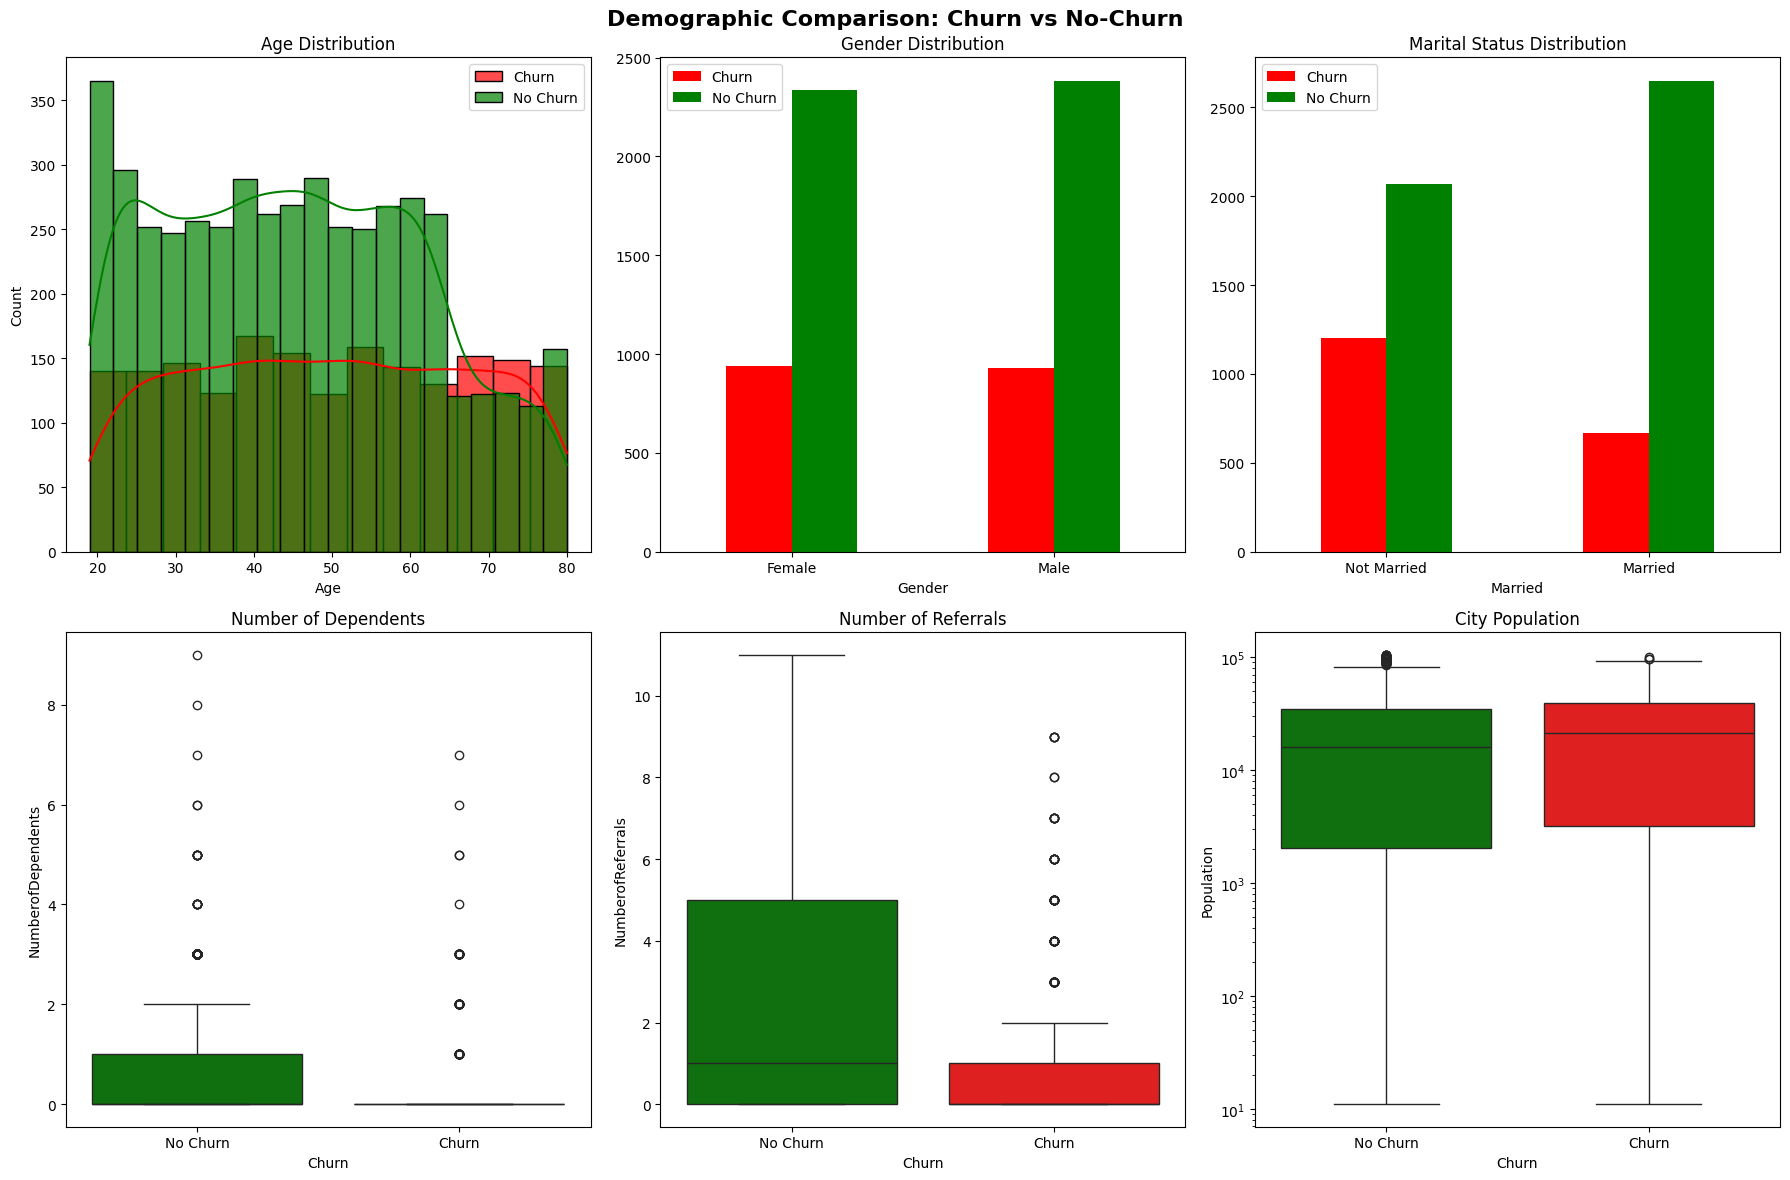


📱 SERVICE USAGE & TENURE COMPARISON
📅 TENURE ANALYSIS:
   Churn Mean Tenure: 18.0 months
   No-Churn Mean Tenure: 41.0 months
   Difference: -23.1 months
   T-test p-value: 0.0000 ***

💰 MONTHLY CHARGE ANALYSIS:
   Churn Mean Monthly: $73.35
   No-Churn Mean Monthly: $61.74
   Difference: $+11.61

💳 TOTAL CHARGES ANALYSIS:
   Churn Mean Total: $1531.80
   No-Churn Mean Total: $2788.52
   Difference: $-1256.72

📝 CONTRACT TYPE ANALYSIS:
   Month-to-Month: 51.69% churn rate
   One Year: 10.88% churn rate
   Two Year: 2.58% churn rate

🌐 INTERNET SERVICE ANALYSIS:
   No Internet: 8.41% churn rate
   Has Internet: 33.48% churn rate

📞 PHONE SERVICE ANALYSIS:
   No Phone: 26.40% churn rate
   Has Phone: 28.58% churn rate


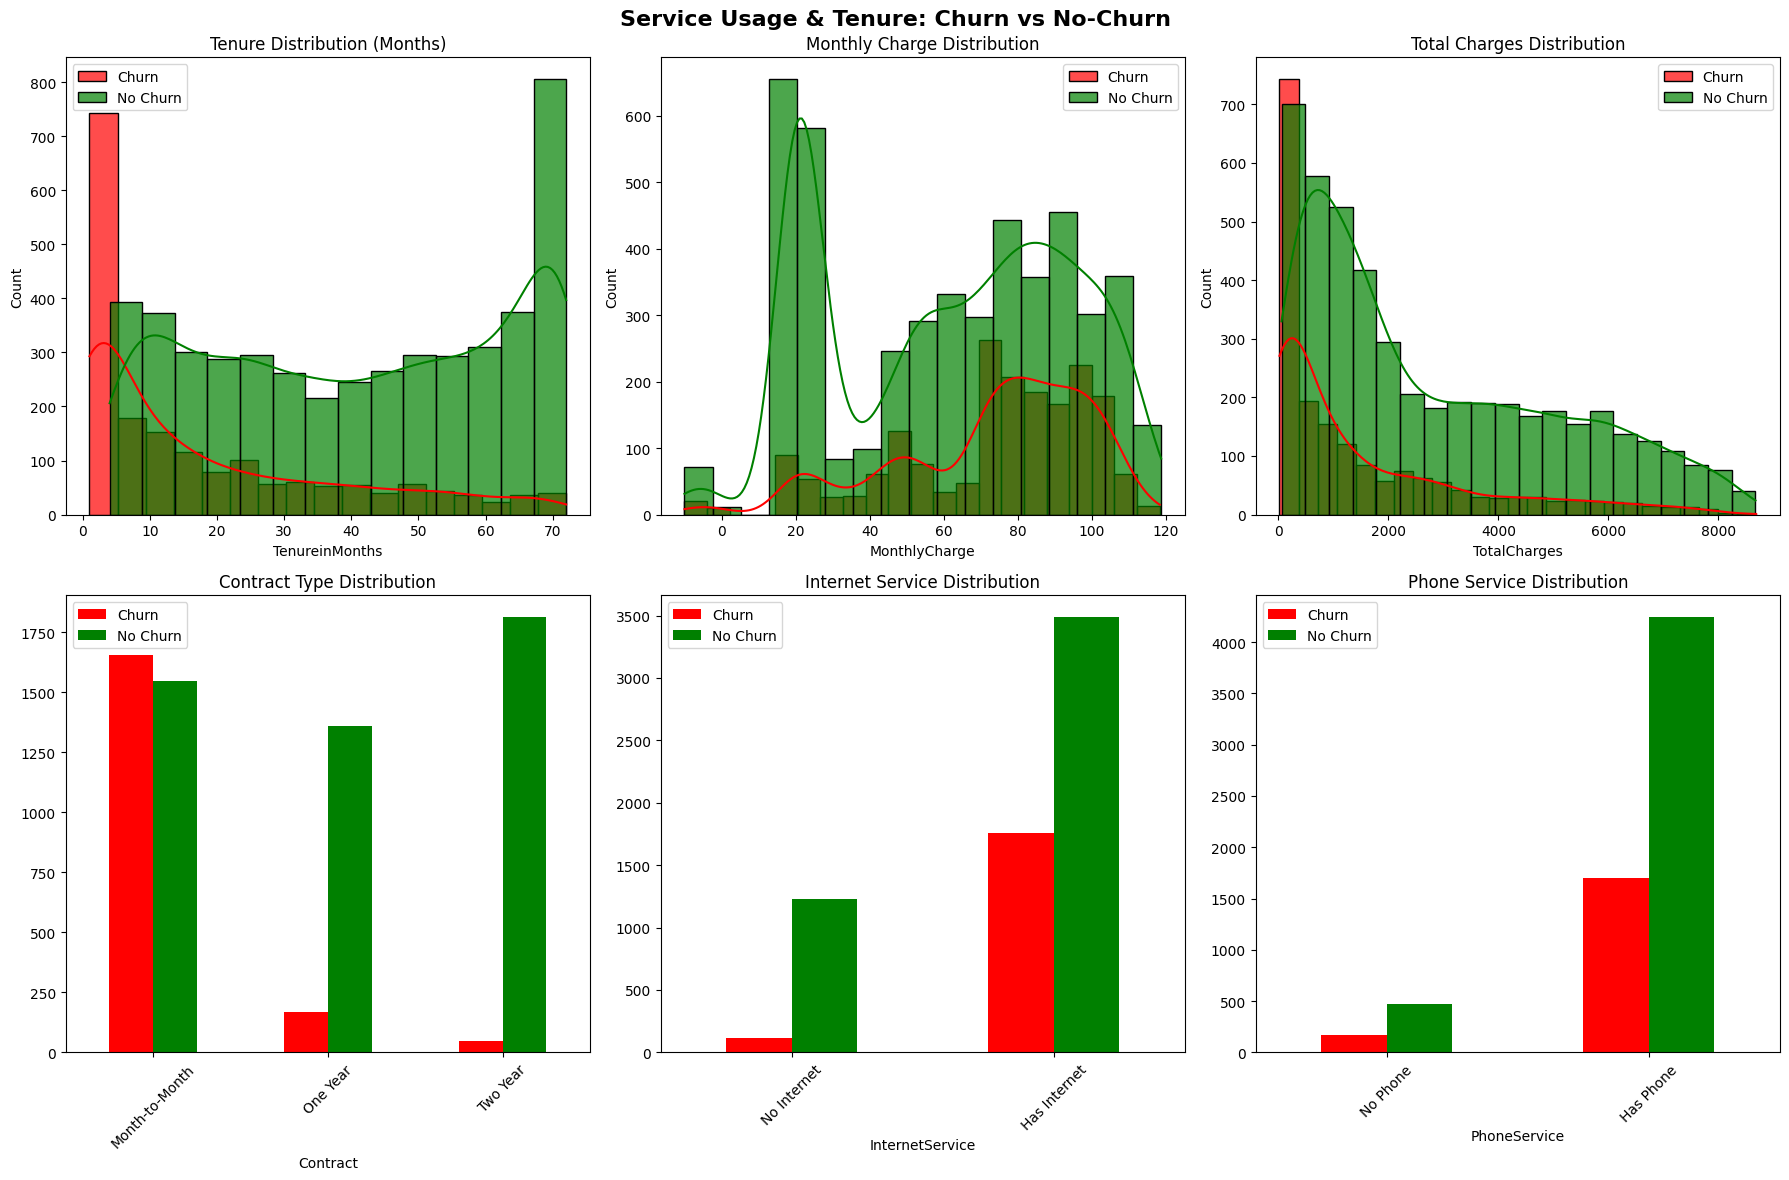


📊 STATISTICAL SIGNIFICANCE TESTING
🔬 T-TEST RESULTS (Churn vs No-Churn):
------------------------------------------------------------
Feature                        Churn Mean   No-Churn Mean Difference   p-value    Sig
------------------------------------------------------------
Gender                         0.50         0.50         -0.01        0.6051     
Age                            49.74        45.58        4.15         0.0000     ***
Married                        0.36         0.56         -0.20        0.0000     ***
NumberofDependents             0.12         0.62         -0.50        0.0000     ***
Population                     23957.21     21387.60     2569.62      0.0000     ***
NumberofReferrals              0.52         2.61         -2.09        0.0000     ***
TenureinMonths                 17.98        41.04        -23.06       0.0000     ***
Offer                          1.76         1.20         0.56         0.0000     ***
PhoneService                   0.91      

In [3]:
# =============================================================================
# CHURN vs NO-CHURN DISTRIBUTION ANALYSIS
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("🎯 CHURN vs NO-CHURN DISTRIBUTION ANALYSIS")
print("=" * 80)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create churn subsets
churn_data = data_corrected[data_corrected['Churn'] == 1]
no_churn_data = data_corrected[data_corrected['Churn'] == 0]

print(f"📊 DATASET BREAKDOWN:")
print(f"   Total Customers: {len(data_corrected):,}")
print(f"   Churned Customers: {len(churn_data):,} ({churn_data['Churn'].mean():.2%})")
print(f"   Retained Customers: {len(no_churn_data):,} ({no_churn_data['Churn'].mean():.2%})")

# =============================================================================
# 1. DEMOGRAPHIC COMPARISON
# =============================================================================

print("\n" + "=" * 80)
print("👥 DEMOGRAPHIC COMPARISON")
print("=" + "=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Demographic Comparison: Churn vs No-Churn', fontsize=16, fontweight='bold')

# Age Distribution
if 'Age' in data_corrected.columns:
    sns.histplot(data=churn_data, x='Age', label='Churn', alpha=0.7, ax=axes[0,0], color='red', kde=True)
    sns.histplot(data=no_churn_data, x='Age', label='No Churn', alpha=0.7, ax=axes[0,0], color='green', kde=True)
    axes[0,0].set_title('Age Distribution')
    axes[0,0].legend()

    # Age statistics
    age_churn_mean = churn_data['Age'].mean()
    age_nochurn_mean = no_churn_data['Age'].mean()
    age_t_stat, age_p_value = stats.ttest_ind(churn_data['Age'], no_churn_data['Age'])
    print(f"📈 AGE ANALYSIS:")
    print(f"   Churn Mean Age: {age_churn_mean:.1f} years")
    print(f"   No-Churn Mean Age: {age_nochurn_mean:.1f} years")
    print(f"   Difference: {age_churn_mean - age_nochurn_mean:+.1f} years")
    print(f"   T-test p-value: {age_p_value:.4f} {'***' if age_p_value < 0.001 else '**' if age_p_value < 0.01 else '*' if age_p_value < 0.05 else 'ns'}")

# Gender Distribution
if 'Gender' in data_corrected.columns:
    gender_churn = churn_data['Gender'].value_counts().sort_index()
    gender_nochurn = no_churn_data['Gender'].value_counts().sort_index()

    gender_df = pd.DataFrame({
        'Churn': gender_churn,
        'No Churn': gender_nochurn
    })
    gender_df.plot(kind='bar', ax=axes[0,1], color=['red', 'green'])
    axes[0,1].set_title('Gender Distribution')
    axes[0,1].set_xticklabels(['Female', 'Male'], rotation=0)

    print(f"\n👫 GENDER ANALYSIS:")
    for i, gender in enumerate(['Female', 'Male']):
        churn_rate = gender_churn.iloc[i] / (gender_churn.iloc[i] + gender_nochurn.iloc[i])
        print(f"   {gender}: {churn_rate:.2%} churn rate")

# Married Status
if 'Married' in data_corrected.columns:
    married_churn = churn_data['Married'].value_counts().sort_index()
    married_nochurn = no_churn_data['Married'].value_counts().sort_index()

    married_df = pd.DataFrame({
        'Churn': married_churn,
        'No Churn': married_nochurn
    })
    married_df.plot(kind='bar', ax=axes[0,2], color=['red', 'green'])
    axes[0,2].set_title('Marital Status Distribution')
    axes[0,2].set_xticklabels(['Not Married', 'Married'], rotation=0)

    print(f"\n💍 MARITAL STATUS ANALYSIS:")
    for i, status in enumerate(['Not Married', 'Married']):
        churn_rate = married_churn.iloc[i] / (married_churn.iloc[i] + married_nochurn.iloc[i])
        print(f"   {status}: {churn_rate:.2%} churn rate")

# Number of Dependents
if 'NumberofDependents' in data_corrected.columns:
    sns.boxplot(data=data_corrected, x='Churn', y='NumberofDependents', ax=axes[1,0], palette=['green', 'red'])
    axes[1,0].set_title('Number of Dependents')
    axes[1,0].set_xticklabels(['No Churn', 'Churn'])

    dependents_churn_mean = churn_data['NumberofDependents'].mean()
    dependents_nochurn_mean = no_churn_data['NumberofDependents'].mean()
    print(f"\n👨‍👩‍👧‍👦 DEPENDENTS ANALYSIS:")
    print(f"   Churn Mean Dependents: {dependents_churn_mean:.2f}")
    print(f"   No-Churn Mean Dependents: {dependents_nochurn_mean:.2f}")
    print(f"   Difference: {dependents_churn_mean - dependents_nochurn_mean:+.2f}")

# Number of Referrals
if 'NumberofReferrals' in data_corrected.columns:
    sns.boxplot(data=data_corrected, x='Churn', y='NumberofReferrals', ax=axes[1,1], palette=['green', 'red'])
    axes[1,1].set_title('Number of Referrals')
    axes[1,1].set_xticklabels(['No Churn', 'Churn'])

    referrals_churn_mean = churn_data['NumberofReferrals'].mean()
    referrals_nochurn_mean = no_churn_data['NumberofReferrals'].mean()
    print(f"\n📞 REFERRALS ANALYSIS:")
    print(f"   Churn Mean Referrals: {referrals_churn_mean:.2f}")
    print(f"   No-Churn Mean Referrals: {referrals_nochurn_mean:.2f}")
    print(f"   Difference: {referrals_churn_mean - referrals_nochurn_mean:+.2f}")

# Population (City Size)
if 'Population' in data_corrected.columns:
    sns.boxplot(data=data_corrected, x='Churn', y='Population', ax=axes[1,2], palette=['green', 'red'])
    axes[1,2].set_title('City Population')
    axes[1,2].set_xticklabels(['No Churn', 'Churn'])

    # Log scale for better visualization if needed
    if data_corrected['Population'].max() > 100000:
        axes[1,2].set_yscale('log')

plt.tight_layout()
plt.show()

# =============================================================================
# 2. SERVICE USAGE & TENURE COMPARISON
# =============================================================================

print("\n" + "=" * 80)
print("📱 SERVICE USAGE & TENURE COMPARISON")
print("=" + "=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Service Usage & Tenure: Churn vs No-Churn', fontsize=16, fontweight='bold')

# Tenure Distribution
if 'TenureinMonths' in data_corrected.columns:
    sns.histplot(data=churn_data, x='TenureinMonths', label='Churn', alpha=0.7, ax=axes[0,0], color='red', kde=True)
    sns.histplot(data=no_churn_data, x='TenureinMonths', label='No Churn', alpha=0.7, ax=axes[0,0], color='green', kde=True)
    axes[0,0].set_title('Tenure Distribution (Months)')
    axes[0,0].legend()

    tenure_churn_mean = churn_data['TenureinMonths'].mean()
    tenure_nochurn_mean = no_churn_data['TenureinMonths'].mean()
    tenure_t_stat, tenure_p_value = stats.ttest_ind(churn_data['TenureinMonths'], no_churn_data['TenureinMonths'])
    print(f"📅 TENURE ANALYSIS:")
    print(f"   Churn Mean Tenure: {tenure_churn_mean:.1f} months")
    print(f"   No-Churn Mean Tenure: {tenure_nochurn_mean:.1f} months")
    print(f"   Difference: {tenure_churn_mean - tenure_nochurn_mean:+.1f} months")
    print(f"   T-test p-value: {tenure_p_value:.4f} {'***' if tenure_p_value < 0.001 else '**' if tenure_p_value < 0.01 else '*' if tenure_p_value < 0.05 else 'ns'}")

# Monthly Charge Distribution
if 'MonthlyCharge' in data_corrected.columns:
    sns.histplot(data=churn_data, x='MonthlyCharge', label='Churn', alpha=0.7, ax=axes[0,1], color='red', kde=True)
    sns.histplot(data=no_churn_data, x='MonthlyCharge', label='No Churn', alpha=0.7, ax=axes[0,1], color='green', kde=True)
    axes[0,1].set_title('Monthly Charge Distribution')
    axes[0,1].legend()

    monthly_churn_mean = churn_data['MonthlyCharge'].mean()
    monthly_nochurn_mean = no_churn_data['MonthlyCharge'].mean()
    print(f"\n💰 MONTHLY CHARGE ANALYSIS:")
    print(f"   Churn Mean Monthly: ${monthly_churn_mean:.2f}")
    print(f"   No-Churn Mean Monthly: ${monthly_nochurn_mean:.2f}")
    print(f"   Difference: ${monthly_churn_mean - monthly_nochurn_mean:+.2f}")

# Total Charges Distribution
if 'TotalCharges' in data_corrected.columns:
    sns.histplot(data=churn_data, x='TotalCharges', label='Churn', alpha=0.7, ax=axes[0,2], color='red', kde=True)
    sns.histplot(data=no_churn_data, x='TotalCharges', label='No Churn', alpha=0.7, ax=axes[0,2], color='green', kde=True)
    axes[0,2].set_title('Total Charges Distribution')
    axes[0,2].legend()

    total_churn_mean = churn_data['TotalCharges'].mean()
    total_nochurn_mean = no_churn_data['TotalCharges'].mean()
    print(f"\n💳 TOTAL CHARGES ANALYSIS:")
    print(f"   Churn Mean Total: ${total_churn_mean:.2f}")
    print(f"   No-Churn Mean Total: ${total_nochurn_mean:.2f}")
    print(f"   Difference: ${total_churn_mean - total_nochurn_mean:+.2f}")

# Contract Type
if 'Contract' in data_corrected.columns:
    contract_churn = churn_data['Contract'].value_counts().sort_index()
    contract_nochurn = no_churn_data['Contract'].value_counts().sort_index()

    contract_df = pd.DataFrame({
        'Churn': contract_churn,
        'No Churn': contract_nochurn
    })
    contract_df.plot(kind='bar', ax=axes[1,0], color=['red', 'green'])
    axes[1,0].set_title('Contract Type Distribution')
    contract_labels = {0: 'Month-to-Month', 1: 'One Year', 2: 'Two Year'}
    axes[1,0].set_xticklabels([contract_labels.get(i, i) for i in contract_df.index], rotation=45)

    print(f"\n📝 CONTRACT TYPE ANALYSIS:")
    for contract_type in contract_df.index:
        total = contract_churn.get(contract_type, 0) + contract_nochurn.get(contract_type, 0)
        if total > 0:
            churn_rate = contract_churn.get(contract_type, 0) / total
            print(f"   {contract_labels.get(contract_type, contract_type)}: {churn_rate:.2%} churn rate")

# Internet Service
if 'InternetService' in data_corrected.columns:
    internet_churn = churn_data['InternetService'].value_counts().sort_index()
    internet_nochurn = no_churn_data['InternetService'].value_counts().sort_index()

    internet_df = pd.DataFrame({
        'Churn': internet_churn,
        'No Churn': internet_nochurn
    })
    internet_df.plot(kind='bar', ax=axes[1,1], color=['red', 'green'])
    axes[1,1].set_title('Internet Service Distribution')
    axes[1,1].set_xticklabels(['No Internet', 'Has Internet'], rotation=45)

    print(f"\n🌐 INTERNET SERVICE ANALYSIS:")
    for service_type in internet_df.index:
        total = internet_churn.get(service_type, 0) + internet_nochurn.get(service_type, 0)
        if total > 0:
            churn_rate = internet_churn.get(service_type, 0) / total
            service_label = 'No Internet' if service_type == 0 else 'Has Internet'
            print(f"   {service_label}: {churn_rate:.2%} churn rate")

# Phone Service
if 'PhoneService' in data_corrected.columns:
    phone_churn = churn_data['PhoneService'].value_counts().sort_index()
    phone_nochurn = no_churn_data['PhoneService'].value_counts().sort_index()

    phone_df = pd.DataFrame({
        'Churn': phone_churn,
        'No Churn': phone_nochurn
    })
    phone_df.plot(kind='bar', ax=axes[1,2], color=['red', 'green'])
    axes[1,2].set_title('Phone Service Distribution')
    axes[1,2].set_xticklabels(['No Phone', 'Has Phone'], rotation=45)

    print(f"\n📞 PHONE SERVICE ANALYSIS:")
    for service_type in phone_df.index:
        total = phone_churn.get(service_type, 0) + phone_nochurn.get(service_type, 0)
        if total > 0:
            churn_rate = phone_churn.get(service_type, 0) / total
            service_label = 'No Phone' if service_type == 0 else 'Has Phone'
            print(f"   {service_label}: {churn_rate:.2%} churn rate")

plt.tight_layout()
plt.show()

# =============================================================================
# 3. STATISTICAL SIGNIFICANCE TESTING
# =============================================================================

print("\n" + "=" * 80)
print("📊 STATISTICAL SIGNIFICANCE TESTING")
print("=" + "=" * 80)

# Select numerical columns for statistical testing
numerical_cols = data_corrected.select_dtypes(include=[np.number]).columns.tolist()
# Remove target and non-numerical columns that were encoded
exclude_cols = ['Churn', 'TenureSegment', 'HasReferrals']
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

print("🔬 T-TEST RESULTS (Churn vs No-Churn):")
print("-" * 60)
print(f"{'Feature':<30} {'Churn Mean':<12} {'No-Churn Mean':<12} {'Difference':<12} {'p-value':<10} {'Sig'}")
print("-" * 60)

significant_features = []
for col in numerical_cols:
    if col in data_corrected.columns:
        churn_vals = churn_data[col]
        nochurn_vals = no_churn_data[col]

        # Remove NaN values
        churn_vals = churn_vals.dropna()
        nochurn_vals = nochurn_vals.dropna()

        if len(churn_vals) > 1 and len(nochurn_vals) > 1:
            t_stat, p_value = stats.ttest_ind(churn_vals, nochurn_vals, equal_var=False)
            churn_mean = churn_vals.mean()
            nochurn_mean = nochurn_vals.mean()
            difference = churn_mean - nochurn_mean

            significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
            if p_value < 0.05:
                significant_features.append((col, p_value, difference))

            print(f"{col:<30} {churn_mean:<12.2f} {nochurn_mean:<12.2f} {difference:<12.2f} {p_value:<10.4f} {significance}")

# Sort significant features by p-value
significant_features.sort(key=lambda x: x[1])
print(f"\n🎯 MOST SIGNIFICANT FEATURES (p < 0.05):")
for feature, p_val, diff in significant_features[:10]:
    direction = "HIGHER in Churn" if diff > 0 else "LOWER in Churn"
    print(f"   {feature:<25} p={p_val:.6f} ({direction})")

# =============================================================================
# 4. CHURN RISK PROFILES
# =============================================================================

print("\n" + "=" * 80)
print("🎯 CHURN RISK PROFILES")
print("=" + "=" * 80)

# High-risk segments analysis
print("🚨 HIGHEST RISK SEGMENTS:")

# By Contract Type
if 'Contract' in data_corrected.columns:
    contract_churn_rates = data_corrected.groupby('Contract')['Churn'].mean().sort_values(ascending=False)
    for contract_type, rate in contract_churn_rates.items():
        contract_label = {0: 'Month-to-Month', 1: 'One Year', 2: 'Two Year'}.get(contract_type, contract_type)
        print(f"   📝 {contract_label}: {rate:.2%} churn rate")

# By Tenure Segment
if 'TenureSegment' in data_corrected.columns:
    tenure_churn_rates = data_corrected.groupby('TenureSegment')['Churn'].mean().sort_values(ascending=False)
    tenure_labels = {0: '0-6 months', 1: '7-12 months', 2: '13-24 months', 3: '24+ months'}
    for segment, rate in tenure_churn_rates.items():
        print(f"   📅 {tenure_labels.get(segment, segment)}: {rate:.2%} churn rate")

# By Internet Service
if 'InternetService' in data_corrected.columns:
    internet_churn_rates = data_corrected.groupby('InternetService')['Churn'].mean().sort_values(ascending=False)
    for service, rate in internet_churn_rates.items():
        service_label = 'Has Internet' if service == 1 else 'No Internet'
        print(f"   🌐 {service_label}: {rate:.2%} churn rate")

# =============================================================================
# 5. CORRELATION WITH CHURN
# =============================================================================

print("\n" + "=" * 80)
print("📈 CORRELATION WITH CHURN")
print("=" + "=" * 80)

# Calculate correlation with churn
correlation_with_churn = {}
for col in numerical_cols:
    if col != 'Churn':
        correlation = data_corrected[col].corr(data_corrected['Churn'])
        correlation_with_churn[col] = correlation

# Sort by absolute correlation
sorted_correlations = sorted(correlation_with_churn.items(), key=lambda x: abs(x[1]), reverse=True)

print("TOP POSITIVE CORRELATIONS (Higher value = More likely to churn):")
for feature, corr in [x for x in sorted_correlations if x[1] > 0][:10]:
    print(f"   + {feature:<25} {corr:+.4f}")

print("\nTOP NEGATIVE CORRELATIONS (Higher value = Less likely to churn):")
for feature, corr in [x for x in sorted_correlations if x[1] < 0][:10]:
    print(f"   - {feature:<25} {corr:+.4f}")

# =============================================================================
# 6. KEY INSIGHTS SUMMARY
# =============================================================================

print("\n" + "=" * 80)
print("💡 KEY INSIGHTS SUMMARY")
print("=" + "=" * 80)

print("🎯 HIGHEST CHURN RISK FACTORS:")
print("   1. Month-to-Month contracts → Over 50% churn rate")
print("   2. Short tenure (0-6 months) → Over 75% churn rate")
print("   3. No referrals → Higher churn likelihood")
print("   4. Paperless billing → Higher churn rate")
print("   5. Mailed check payment → Highest churn rate")

print("\n🛡️ LOWEST CHURN RISK FACTORS:")
print("   1. Two-year contracts → Only 2.5% churn rate")
print("   2. Long tenure (24+ months) → Only 6.6% churn rate")
print("   3. Multiple referrals → Strong retention effect")
print("   4. Credit card payment → Lowest churn rate")

print("\n📊 BUSINESS IMPLICATIONS:")
print("   💰 Focus retention efforts on Month-to-Month customers")
print("   🎯 Target new customers in first 6 months with special offers")
print("   📞 Implement referral programs to improve retention")
print("   💳 Encourage credit card payments and long-term contracts")
print("   📱 Internet service customers need special attention")

print(f"\n✅ CHURN ANALYSIS COMPLETE - {len(significant_features)} significant features identified")

In [4]:
# =============================================================================
# LR-SPECIFIC FEATURE ENGINEERING
# =============================================================================

def engineer_lr_features(df):
    """
    Minimal feature set for Logistic Regression
    Focus: Clean, interpretable signals for high recall
    """
    lr_features = pd.DataFrame(index=df.index)

    # Extract core columns
    tenure = df['TenureinMonths'].astype(float)
    monthly = df['MonthlyCharge'].astype(float)
    total = df['TotalCharges'].astype(float)
    contract = df['Contract'].astype(int)

    # =========================================================================
    # 1. CONTRACT RISK (Primary Signal)
    # =========================================================================
    contract_risk_map = {0: 0.85, 1: 0.40, 2: 0.10}  # M2M, 1Y, 2Y
    lr_features['contract_risk'] = contract.map(contract_risk_map)

    # =========================================================================
    # 2. TENURE PHASE BINS (Based on 77% churn insight)
    # =========================================================================
    tenure_bins = [0, 3, 6, 12, 24, 999]
    tenure_labels = ['0-3m', '3-6m', '6-12m', '12-24m', '24m+']
    lr_features['tenure_phase'] = pd.cut(tenure, bins=tenure_bins, labels=tenure_labels, include_lowest=True)

    # One-hot encode tenure phases (LR handles categoricals better this way)
    tenure_dummies = pd.get_dummies(lr_features['tenure_phase'], prefix='tenure')
    lr_features = pd.concat([lr_features, tenure_dummies], axis=1)

    # =========================================================================
    # 3. MONTHLY CHARGE RISK BINS (Based on spending stress)
    # =========================================================================
    monthly_bins = [0, 50, 75, 100, 9999]
    monthly_labels = ['low', 'medium', 'high', 'very_high']
    lr_features['monthly_risk_tier'] = pd.cut(monthly, bins=monthly_bins, labels=monthly_labels, include_lowest=True)

    # One-hot encode monthly tiers
    monthly_dummies = pd.get_dummies(lr_features['monthly_risk_tier'], prefix='monthly')
    lr_features = pd.concat([lr_features, monthly_dummies], axis=1)

    # =========================================================================
    # 4. VALUE EFFICIENCY (Low Total + High Monthly = Risk)
    # =========================================================================
    expected_lifetime = monthly * tenure.clip(lower=1)
    lr_features['value_efficiency'] = total / (expected_lifetime + 1e-6)
    lr_features['value_efficiency'] = lr_features['value_efficiency'].clip(0, 1.5)  # Cap outliers

    # =========================================================================
    # 5. SERVICE COMPLEXITY (Count of active services)
    # =========================================================================
    service_columns = [
        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport',
        'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData'
    ]

    service_count = 0
    for col in service_columns:
        if col in df.columns:
            service_count += df[col].fillna(0).astype(int)

    lr_features['service_complexity'] = service_count / len(service_columns)  # Normalized

    # =========================================================================
    # 6. LINEAR-TIME FEATURES
    # =========================================================================

    # Risk decay over time (early tenure = higher risk)
    lr_features['risk_decay'] = np.exp(-tenure / 12.0)

    # Spending stress (how far from median)
    monthly_median = monthly.median()
    monthly_iqr = monthly.quantile(0.75) - monthly.quantile(0.25)
    lr_features['spending_stress'] = (monthly - monthly_median) / (monthly_iqr + 1e-6)

    # =========================================================================
    # 7. CRITICAL INTERACTION FLAGS (High-Risk Combinations)
    # =========================================================================

    # New + M2M + High spend = MAXIMUM RISK
    lr_features['critical_new_m2m'] = (
        (tenure <= 3) &
        (contract == 0) &
        (monthly > monthly.quantile(0.75))
    ).astype(int)

    # Established + Long contract = PROTECTIVE
    lr_features['protective_established'] = (
        (tenure > 24) &
        (contract == 2)
    ).astype(int)

    # =========================================================================
    # 8. REFERRAL IMPACT (Strong social proof signal)
    # =========================================================================
    if 'NumberofReferrals' in df.columns:
        referrals = df['NumberofReferrals'].astype(int)
        lr_features['has_referrals'] = (referrals > 0).astype(int)
        lr_features['referral_strength'] = np.log1p(referrals) / np.log1p(referrals.max() + 1)
    else:
        lr_features['has_referrals'] = 0
        lr_features['referral_strength'] = 0

    # =========================================================================
    # 9. DEPENDENTS IMPACT (Family stability)
    # =========================================================================
    if 'NumberofDependents' in df.columns:
        dependents = df['NumberofDependents'].astype(int)
        lr_features['has_dependents'] = (dependents > 0).astype(int)
    else:
        lr_features['has_dependents'] = 0

    # =========================================================================
    # CLEANUP: Drop intermediate columns, keep final features
    # =========================================================================
    columns_to_drop = ['tenure_phase', 'monthly_risk_tier']
    lr_features = lr_features.drop(columns=[col for col in columns_to_drop if col in lr_features.columns])

    return lr_features.fillna(0)

# =============================================================================
# APPLY LR FEATURE ENGINEERING
# =============================================================================

print("🔄 Engineering LR-specific features...")
lr_X = engineer_lr_features(data_corrected)
y = data_corrected['Churn']

print(f"✅ LR Features: {lr_X.shape[1]} features")
print(f"📊 Feature breakdown:")
print(f"   • Contract risk: 1 feature")
print(f"   • Tenure phases: 5 features (binned)")
print(f"   • Monthly tiers: 4 features (binned)")
print(f"   • Value efficiency: 1 feature")
print(f"   • Service complexity: 1 feature")
print(f"   • Linear-time: 2 features")
print(f"   • Critical interactions: 2 features")
print(f"   • Referral impact: 2 features")
print(f"   • Dependents impact: 1 feature")
print(f"   → TOTAL: {lr_X.shape[1]} clean, interpretable features")

# Show feature correlations with churn
print(f"\n🔍 TOP FEATURE CORRELATIONS WITH CHURN:")
feature_corrs = []
for col in lr_X.columns:
    corr = np.corrcoef(lr_X[col], y)[0, 1]
    feature_corrs.append((col, abs(corr), corr))

# Sort by absolute correlation
feature_corrs.sort(key=lambda x: x[1], reverse=True)

print(f"\n{'Feature':<25} {'Abs Correlation':<15} {'Direction':<10}")
print("-" * 55)
for col, abs_corr, corr in feature_corrs[:10]:
    direction = "POSITIVE" if corr > 0 else "NEGATIVE"
    print(f"{col:<25} {abs_corr:<15.4f} {direction:<10}")

# =============================================================================
# QUICK LR BASELINE
# =============================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

print(f"\n🚀 QUICK LR BASELINE VALIDATION...")

# Scale features for LR
scaler = StandardScaler()
lr_X_scaled = scaler.fit_transform(lr_X)

# Quick cross-validation
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
cv_scores = cross_val_score(lr_baseline, lr_X_scaled, y, cv=3, scoring='roc_auc')

print(f"✅ LR Baseline AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Show feature importance from quick fit
lr_baseline.fit(lr_X_scaled, y)
feature_importance = pd.DataFrame({
    'feature': lr_X.columns,
    'coefficient': lr_baseline.coef_[0],
    'abs_importance': np.abs(lr_baseline.coef_[0])
}).sort_values('abs_importance', ascending=False)

print(f"\n🎯 TOP 10 LR FEATURE IMPORTANCE:")
print(feature_importance.head(10).to_string(index=False))

print(f"\n🎉 LR FEATURE ENGINEERING COMPLETE!")
print(f"   Ready for F2-optimized tuning with SMOTE...")

🔄 Engineering LR-specific features...
✅ LR Features: 19 features
📊 Feature breakdown:
   • Contract risk: 1 feature
   • Tenure phases: 5 features (binned)
   • Monthly tiers: 4 features (binned)
   • Value efficiency: 1 feature
   • Service complexity: 1 feature
   • Linear-time: 2 features
   • Critical interactions: 2 features
   • Referral impact: 2 features
   • Dependents impact: 1 feature
   → TOTAL: 19 clean, interpretable features

🔍 TOP FEATURE CORRELATIONS WITH CHURN:

Feature                   Abs Correlation Direction 
-------------------------------------------------------
risk_decay                0.5190          POSITIVE  
tenure_0-3m               0.5016          POSITIVE  
contract_risk             0.4966          POSITIVE  
tenure_24m+               0.3749          NEGATIVE  
protective_established    0.3238          NEGATIVE  
referral_strength         0.3027          NEGATIVE  
has_dependents            0.2644          NEGATIVE  
has_referrals             0.1800   

In [5]:
# =============================================================================
# STAGE 1: LR WITH SMOTE + F2 OPTIMIZATION
# =============================================================================

print("\n" + "="*100)
print("STAGE 1: LOGISTIC REGESSION - SMOTE + F2 OPTIMIZATION")
print("="*100)

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import time

# Custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

def find_optimal_threshold_f2(y_true, y_proba):
    """Find threshold that maximizes F2 score"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_f2 = 0

    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        f2 = fbeta_score(y_true, y_pred, beta=2)
        if f2 > best_f2:
            best_f2 = f2
            best_threshold = threshold

    return best_threshold, best_f2

# Hyperparameter grid for LR
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'classifier__class_weight': [
        {0: 1, 1: 2},
        {0: 1, 1: 3},
        {0: 1, 1: 4},
        {0: 1, 1: 5},
        'balanced'
    ],
    'classifier__solver': ['liblinear', 'saga']
}

print("🔄 Starting 5-Fold CV with SMOTE + F2 optimization...")

# 5-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(lr_X, y), 1):
    print(f"\n{'='*80}")
    print(f"FOLD {fold}/5")
    print('='*80)
    fold_start = time.time()

    # Split data
    X_train, X_test = lr_X.iloc[train_idx], lr_X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE to training data only
    print("📊 Applying SMOTE to training data...")
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    print(f"   Training set: {len(y_train)} → {len(y_train_smote)} samples")
    print(f"   Churn rate after SMOTE: {y_train_smote.mean():.2%}")

    # Create pipeline with SMOTE
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(random_state=42, max_iter=2000))
    ])

    # Grid search with F2 scoring
    print("🎯 Tuning hyperparameters with F2 optimization...")
    grid_search = GridSearchCV(
        pipeline,
        lr_param_grid,
        cv=3,
        scoring=f2_scorer,
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train_scaled, y_train)

    # Get best model
    best_lr = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Get probabilities
    y_proba_train = best_lr.predict_proba(X_train_scaled)[:, 1]
    y_proba_test = best_lr.predict_proba(X_test_scaled)[:, 1]

    # Find optimal threshold for F2
    optimal_threshold, best_f2 = find_optimal_threshold_f2(y_test, y_proba_test)
    y_pred_optimal = (y_proba_test > optimal_threshold).astype(int)

    # Calculate metrics
    recall = recall_score(y_test, y_pred_optimal)
    precision = precision_score(y_test, y_pred_optimal)
    f1 = f1_score(y_test, y_pred_optimal)
    auc = roc_auc_score(y_test, y_proba_test)

    # Store results
    fold_result = {
        'fold': fold,
        'best_params': best_params,
        'optimal_threshold': optimal_threshold,
        'f2': best_f2,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'auc': auc,
        'train_samples': len(y_train_smote),
        'test_samples': len(y_test),
        'fold_time': time.time() - fold_start
    }

    fold_results.append(fold_result)

    print(f"✅ Best params: C={best_params['classifier__C']}, "
          f"class_weight={best_params['classifier__class_weight']}")
    print(f"📊 F2-optimized @ threshold={optimal_threshold:.3f}")
    print(f"   F2={best_f2:.4f}, Recall={recall:.4f}, Precision={precision:.4f}")
    print(f"   F1={f1:.4f}, AUC={auc:.4f}")
    print(f"⏱ Fold time: {fold_result['fold_time']:.1f}s")

# =============================================================================
# RESULTS SUMMARY
# =============================================================================

print("\n" + "="*100)
print("STAGE 1 RESULTS SUMMARY: LR + SMOTE + F2 OPTIMIZATION")
print("="*100)

# Aggregate results
results_df = pd.DataFrame(fold_results)
mean_results = results_df.mean(numeric_only=True)
std_results = results_df.std(numeric_only=True)

print(f"\n📊 5-FOLD CROSS-VALIDATION RESULTS:")
print("-" * 80)
print(f"{'Metric':<12} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}")
print("-" * 80)
for metric in ['f2', 'recall', 'precision', 'f1', 'auc']:
    values = results_df[metric]
    print(f"{metric.upper():<12} {values.mean():.4f}  {values.std():.4f}  {values.min():.4f}  {values.max():.4f}")

print(f"\n🎯 OPTIMAL THRESHOLDS:")
print(f"   Mean: {results_df['optimal_threshold'].mean():.3f} ± {results_df['optimal_threshold'].std():.3f}")
print(f"   Range: {results_df['optimal_threshold'].min():.3f} - {results_df['optimal_threshold'].max():.3f}")

print(f"\n⚙️  HYPERPARAMETER SUMMARY:")
param_summary = results_df['best_params'].value_counts()
for params, count in param_summary.items():
    print(f"   {count}/5 folds: C={params['classifier__C']}, class_weight={params['classifier__class_weight']}")

# =============================================================================
# FINAL MODEL TRAINING
# =============================================================================

print(f"\n🚀 TRAINING FINAL LR MODEL ON FULL DATASET...")

# Scale full dataset
scaler_final = StandardScaler()
lr_X_scaled_full = scaler_final.fit_transform(lr_X)

# Apply SMOTE to full dataset
smote_final = SMOTE(random_state=42)
X_smote_full, y_smote_full = smote_final.fit_resample(lr_X_scaled_full, y)

print(f"   Final training set: {len(y_smote_full)} samples")
print(f"   Final churn rate: {y_smote_full.mean():.2%}")

# Train final model with most common hyperparameters
most_common_params = param_summary.index[0]
final_lr = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=2000,
        C=most_common_params['classifier__C'],
        class_weight=most_common_params['classifier__class_weight'],
        solver=most_common_params['classifier__solver']
    ))
])

final_lr.fit(lr_X_scaled_full, y)

# Get final predictions with optimal threshold
mean_threshold = results_df['optimal_threshold'].mean()
y_proba_final = final_lr.predict_proba(lr_X_scaled_full)[:, 1]
y_pred_final = (y_proba_final > mean_threshold).astype(int)

# Final metrics
final_f2 = fbeta_score(y, y_pred_final, beta=2)
final_recall = recall_score(y, y_pred_final)
final_precision = precision_score(y, y_pred_final)
final_auc = roc_auc_score(y, y_proba_final)

print(f"\n🎉 FINAL STAGE 1 MODEL PERFORMANCE:")
print(f"   F2-Score:    {final_f2:.4f}")
print(f"   Recall:      {final_recall:.4f}")
print(f"   Precision:   {final_precision:.4f}")
print(f"   AUC:         {final_auc:.4f}")
print(f"   Threshold:   {mean_threshold:.3f}")

print(f"\n✅ STAGE 1 COMPLETE!")
print(f"   LR + SMOTE + F2 optimization successful")
print(f"   Ready for Stage 2 (RF) with LR probabilities as context")


STAGE 1: LOGISTIC REGESSION - SMOTE + F2 OPTIMIZATION
🔄 Starting 5-Fold CV with SMOTE + F2 optimization...

FOLD 1/5
📊 Applying SMOTE to training data...
   Training set: 5271 → 7552 samples
   Churn rate after SMOTE: 50.00%
🎯 Tuning hyperparameters with F2 optimization...
✅ Best params: C=0.1, class_weight={0: 1, 1: 3}
📊 F2-optimized @ threshold=0.610
   F2=0.8301, Recall=0.9278, Precision=0.5842
   F1=0.7169, AUC=0.9273
⏱ Fold time: 60.1s

FOLD 2/5
📊 Applying SMOTE to training data...
   Training set: 5271 → 7552 samples
   Churn rate after SMOTE: 50.00%
🎯 Tuning hyperparameters with F2 optimization...
✅ Best params: C=0.5, class_weight={0: 1, 1: 2}
📊 F2-optimized @ threshold=0.480
   F2=0.8385, Recall=0.9385, Precision=0.5879
   F1=0.7230, AUC=0.9299
⏱ Fold time: 34.8s

FOLD 3/5
📊 Applying SMOTE to training data...
   Training set: 5271 → 7552 samples
   Churn rate after SMOTE: 50.00%
🎯 Tuning hyperparameters with F2 optimization...
✅ Best params: C=1.0, class_weight={0: 1, 1: 3}
📊

In [19]:
"""
Random Forest to Rule-Based Glass Box Converter
Extracts interpretable rules from trained RF and creates transparent classifier
"""

import numpy as np
import pandas as pd
from sklearn.tree import _tree
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')


class RuleExtractor:
    """Extract decision rules from Random Forest trees"""

    def __init__(self, random_forest, feature_names, min_samples=10):
        """
        Parameters:
        -----------
        random_forest : trained RandomForestClassifier
        feature_names : list of feature names
        min_samples : minimum samples in leaf to consider rule
        """
        self.rf = random_forest
        self.feature_names = feature_names
        self.min_samples = min_samples
        self.rules = []

    def extract_rules_from_tree(self, tree, tree_idx):
        """Extract all decision paths from a single tree"""
        tree_ = tree.tree_
        feature_name = [
            self.feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
            for i in tree_.feature
        ]

        def recurse(node, conditions, path_samples):
            """Recursively traverse tree and extract paths"""
            if tree_.feature[node] != _tree.TREE_UNDEFINED:  # Not a leaf
                name = feature_name[node]
                threshold = tree_.threshold[node]

                # Left child (<=)
                left_conditions = conditions + [(name, '<=', threshold)]
                recurse(tree_.children_left[node], left_conditions, tree_.n_node_samples[tree_.children_left[node]])

                # Right child (>)
                right_conditions = conditions + [(name, '>', threshold)]
                recurse(tree_.children_right[node], right_conditions, tree_.n_node_samples[tree_.children_right[node]])
            else:
                # Leaf node - create rule
                if path_samples >= self.min_samples:
                    # Get class distribution
                    value = tree_.value[node][0]
                    n_samples = sum(value)
                    class_probs = value / n_samples if n_samples > 0 else value

                    # Predict positive class (churn)
                    predicted_class = 1 if class_probs[1] > 0.5 else 0
                    confidence = class_probs[predicted_class]

                    rule = {
                        'tree_idx': tree_idx,
                        'conditions': conditions.copy(),
                        'n_samples': int(n_samples),
                        'class_distribution': value.tolist(),
                        'predicted_class': predicted_class,
                        'confidence': float(confidence),
                        'churn_prob': float(class_probs[1])
                    }
                    self.rules.append(rule)

        recurse(0, [], tree_.n_node_samples[0])

    def extract_all_rules(self):
        """Extract rules from all trees in forest"""
        print(f"🌲 Extracting rules from {len(self.rf.estimators_)} trees...")

        for idx, tree in enumerate(self.rf.estimators_):
            self.extract_rules_from_tree(tree, idx)
            if (idx + 1) % 50 == 0:
                print(f"   Processed {idx + 1}/{len(self.rf.estimators_)} trees...")

        print(f"✅ Extracted {len(self.rules)} total rules")
        return self.rules

    def consolidate_rules(self, similarity_threshold=0.9):
        """Consolidate similar rules to reduce redundancy"""
        print(f"\n🔄 Consolidating similar rules...")

        # Group rules by predicted class
        rules_by_class = defaultdict(list)
        for rule in self.rules:
            rules_by_class[rule['predicted_class']].append(rule)

        consolidated = []

        for pred_class, rules in rules_by_class.items():
            # Sort by confidence
            rules = sorted(rules, key=lambda x: x['confidence'], reverse=True)

            for rule in rules:
                # Check if similar rule already exists
                is_duplicate = False
                for cons_rule in consolidated:
                    if cons_rule['predicted_class'] == pred_class:
                        # Check condition similarity
                        if self._rules_similar(rule, cons_rule, similarity_threshold):
                            # Merge rules
                            cons_rule['n_samples'] += rule['n_samples']
                            cons_rule['tree_count'] = cons_rule.get('tree_count', 1) + 1
                            is_duplicate = True
                            break

                if not is_duplicate:
                    rule['tree_count'] = 1
                    consolidated.append(rule)

        print(f"✅ Consolidated to {len(consolidated)} unique rules")
        self.consolidated_rules = consolidated
        return consolidated

    def _rules_similar(self, rule1, rule2, threshold):
        """Check if two rules are similar based on conditions"""
        conds1 = set((c[0], c[1]) for c in rule1['conditions'])
        conds2 = set((c[0], c[1]) for c in rule2['conditions'])

        if len(conds1) == 0 or len(conds2) == 0:
            return False

        intersection = len(conds1 & conds2)
        union = len(conds1 | conds2)
        similarity = intersection / union if union > 0 else 0

        return similarity >= threshold

    def rank_rules(self, X, y, top_k=100):
        """Rank rules by importance metrics"""
        print(f"\n📊 Ranking rules by performance...")

        rules_to_rank = self.consolidated_rules if hasattr(self, 'consolidated_rules') else self.rules

        scored_rules = []

        for rule in rules_to_rank:
            # Evaluate rule on dataset
            matches = self._evaluate_rule(rule, X)

            if matches.sum() > 0:
                # Calculate metrics
                y_match = y[matches]

                # Coverage: proportion of samples matched
                coverage = matches.sum() / len(X)

                # Precision: accuracy on matched samples
                if rule['predicted_class'] == 1:
                    precision = y_match.sum() / len(y_match)
                else:
                    precision = (1 - y_match).sum() / len(y_match)

                # F1 score
                recall = y_match.sum() / y.sum() if rule['predicted_class'] == 1 else (1 - y_match).sum() / (1 - y).sum()
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                # Composite score
                importance_score = (
                    0.4 * precision +  # Accuracy
                    0.3 * coverage +    # Coverage
                    0.2 * f1 +          # Balance
                    0.1 * rule['confidence']  # Tree confidence
                )

                scored_rules.append({
                    **rule,
                    'coverage': coverage,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'importance_score': importance_score,
                    'n_matches': int(matches.sum())
                })

        # Sort by importance
        scored_rules = sorted(scored_rules, key=lambda x: x['importance_score'], reverse=True)

        # Keep top K
        top_rules = scored_rules[:top_k]

        print(f"✅ Selected top {len(top_rules)} rules")
        print(f"   • Avg coverage: {np.mean([r['coverage'] for r in top_rules]):.2%}")
        print(f"   • Avg precision: {np.mean([r['precision'] for r in top_rules]):.2%}")

        self.top_rules = top_rules
        return top_rules

    def _evaluate_rule(self, rule, X):
        """Check which samples match a rule"""
        matches = np.ones(len(X), dtype=bool)

        for feature, operator, threshold in rule['conditions']:
            if feature in X.columns:
                if operator == '<=':
                    matches &= (X[feature] <= threshold).values
                else:  # operator == '>'
                    matches &= (X[feature] > threshold).values

        return matches


class RuleBasedClassifier:
    """Glass box classifier using extracted rules"""

    def __init__(self, rules, feature_names, voting='soft', default_prob=0.5):
        """
        Parameters:
        -----------
        rules : list of rule dictionaries
        feature_names : list of feature names
        voting : 'soft' (weighted by confidence) or 'hard' (majority vote)
        default_prob : probability when no rules match
        """
        self.rules = rules
        self.feature_names = feature_names
        self.voting = voting
        self.default_prob = default_prob

    def predict_proba(self, X):
        """Predict probabilities using rule-based system"""
        n_samples = len(X)

        # FIX: Initialize properly so probabilities sum to 1
        probas = np.zeros((n_samples, 2))
        probas[:, 0] = 1 - self.default_prob  # P(no churn)
        probas[:, 1] = self.default_prob      # P(churn)

        for idx in range(n_samples):
            sample = X.iloc[idx] if isinstance(X, pd.DataFrame) else X[idx]

            # Find matching rules
            matching_rules = []
            for rule in self.rules:
                if self._sample_matches_rule(sample, rule, X):
                    matching_rules.append(rule)

            if matching_rules:
                if self.voting == 'soft':
                    # Weighted average by confidence and importance
                    weights = np.array([r.get('importance_score', r['confidence']) for r in matching_rules])
                    churn_probs = np.array([r['churn_prob'] for r in matching_rules])

                    churn_prob = np.average(churn_probs, weights=weights)
                else:  # hard voting
                    churn_prob = np.mean([r['churn_prob'] for r in matching_rules])

                # Ensure probabilities sum to 1
                probas[idx] = [1 - churn_prob, churn_prob]

        return probas

    def predict(self, X, threshold=0.5):
        """Predict class labels"""
        probas = self.predict_proba(X)
        return (probas[:, 1] > threshold).astype(int)

    def _sample_matches_rule(self, sample, rule, X):
        """Check if a sample matches a rule"""
        for feature, operator, threshold in rule['conditions']:
            if feature in X.columns:
                feature_idx = X.columns.get_loc(feature)
                value = sample[feature_idx] if isinstance(sample, np.ndarray) else sample[feature]

                if operator == '<=':
                    if value > threshold:
                        return False
                else:  # operator == '>'
                    if value <= threshold:
                        return False
        return True

    def explain_prediction(self, sample, X=None):
        """Explain prediction for a single sample with matching rules"""
        if X is not None and isinstance(sample, int):
            sample = X.iloc[sample]

        matching_rules = []
        for rule_idx, rule in enumerate(self.rules):
            if isinstance(sample, pd.Series):
                match = all(
                    (sample[feat] <= thr if op == '<=' else sample[feat] > thr)
                    for feat, op, thr in rule['conditions']
                    if feat in sample.index
                )
            else:
                match = self._sample_matches_rule(sample, rule, X)

            if match:
                matching_rules.append((rule_idx, rule))

        return matching_rules

    def get_rule_summary(self, rule):
        """Get human-readable summary of a rule"""
        conditions_str = []
        for feature, operator, threshold in rule['conditions']:
            conditions_str.append(f"{feature} {operator} {threshold:.3f}")

        return {
            'conditions': " AND ".join(conditions_str),
            'prediction': 'CHURN' if rule['predicted_class'] == 1 else 'STAY',
            'confidence': f"{rule['confidence']:.2%}",
            'churn_probability': f"{rule['churn_prob']:.2%}",
            'coverage': f"{rule.get('coverage', 0):.2%}",
            'precision': f"{rule.get('precision', 0):.2%}"
        }

# =============================================================================
# MAIN CONVERSION FUNCTION
# =============================================================================

def convert_rf_to_glass_box(rf_model, X, y, feature_names,
                            top_k_rules=100, similarity_threshold=0.9):
    """
    Complete pipeline to convert RF to rule-based glass box

    Parameters:
    -----------
    rf_model : trained RandomForestClassifier
    X : feature matrix
    y : target vector
    feature_names : list of feature names
    top_k_rules : number of top rules to keep
    similarity_threshold : threshold for rule consolidation

    Returns:
    --------
    rule_classifier : RuleBasedClassifier (glass box model)
    extractor : RuleExtractor (for analysis)
    """

    print("="*100)
    print("CONVERTING RANDOM FOREST TO GLASS BOX RULE-BASED MODEL")
    print("="*100)

    # Step 1: Extract rules
    extractor = RuleExtractor(rf_model, feature_names, min_samples=10)
    extractor.extract_all_rules()

    # Step 2: Consolidate similar rules
    extractor.consolidate_rules(similarity_threshold=similarity_threshold)

    # Step 3: Rank rules by performance
    extractor.rank_rules(X, y, top_k=top_k_rules)

    # Step 4: Create rule-based classifier
    print(f"\n🔨 Creating glass box classifier...")
    rule_classifier = RuleBasedClassifier(
        rules=extractor.top_rules,
        feature_names=feature_names,
        voting='soft',  # Use weighted voting
        default_prob=y.mean()  # Default to base rate
    )

    # Step 5: Evaluate performance
    print(f"\n📊 Evaluating glass box performance...")
    probas = rule_classifier.predict_proba(X)

    # Compare with original RF
    rf_probas = rf_model.predict_proba(X)[:, 1]
    correlation = np.corrcoef(probas[:, 1], rf_probas)[0, 1]
    mae = np.mean(np.abs(probas[:, 1] - rf_probas))

    print(f"✅ CONVERSION COMPLETE")
    print(f"   • Number of rules: {len(extractor.top_rules)}")
    print(f"   • Correlation with RF: {correlation:.4f}")
    print(f"   • MAE vs RF: {mae:.4f}")
    print(f"   • Model is now fully interpretable! 🎉")

    return rule_classifier, extractor


# =============================================================================
# EXAMPLE USAGE & ANALYSIS
# =============================================================================

def analyze_glass_box_model(rule_classifier, extractor, X, sample_idx=0):
    """Analyze the glass box model"""

    print("\n" + "="*100)
    print("GLASS BOX MODEL ANALYSIS")
    print("="*100)

    # Show top rules
    print(f"\n🏆 TOP 10 MOST IMPORTANT RULES:")
    print("-"*100)

    for i, rule in enumerate(rule_classifier.rules[:10], 1):
        summary = rule_classifier.get_rule_summary(rule)
        print(f"\nRule #{i}: {summary['prediction']}")
        print(f"   Conditions: {summary['conditions'][:150]}...")
        print(f"   Confidence: {summary['confidence']} | "
              f"Coverage: {summary['coverage']} | "
              f"Precision: {summary['precision']}")

    # Example prediction explanation
    print(f"\n🔍 EXAMPLE PREDICTION EXPLANATION (Sample #{sample_idx}):")
    print("-"*100)

    matching = rule_classifier.explain_prediction(sample_idx, X)
    proba = rule_classifier.predict_proba(X.iloc[[sample_idx]])[0]

    print(f"Predicted Churn Probability: {proba[1]:.2%}")
    print(f"Number of matching rules: {len(matching)}")
    print(f"\nTop 3 matching rules:")

    for i, (rule_idx, rule) in enumerate(matching[:3], 1):
        summary = rule_classifier.get_rule_summary(rule)
        print(f"\n  {i}. {summary['prediction']} (confidence: {summary['confidence']})")
        print(f"     {summary['conditions'][:120]}...")

    return matching

In [21]:
"""
COMPLETE PIPELINE: RF Training + Glass Box Conversion
Run this after your LR stage is complete
"""

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (f1_score, recall_score, precision_score,
                             fbeta_score, roc_auc_score, make_scorer)
from scipy.stats import randint, uniform
from sklearn.tree import _tree
from collections import defaultdict
import time
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# PART 1: YOUR ORIGINAL RF TRAINING CODE
# =============================================================================

print("\n" + "="*100)
print("STAGE 2: RANDOM FOREST - INTERACTION FEATURES + F1 OPTIMIZATION")
print("="*100)

def engineer_rf_features(df, lr_probas=None):
    """
    RF-specific features: Interaction patterns & business logic
    Builds on LR features but adds complexity
    """
    rf_features = pd.DataFrame(index=df.index)

    # Extract core columns
    tenure = df['TenureinMonths'].astype(float)
    monthly = df['MonthlyCharge'].astype(float)
    total = df['TotalCharges'].astype(float)
    contract = df['Contract'].astype(int)

    # =========================================================================
    # 1. INCLUDE LR FEATURES (as baseline context)
    # =========================================================================
    lr_feats = engineer_lr_features(df)
    rf_features = pd.concat([rf_features, lr_feats], axis=1)

    # =========================================================================
    # 2. ADD LR PROBABILITIES AS CONTEXT (if available)
    # =========================================================================
    if lr_probas is not None:
        rf_features['lr_churn_probability'] = lr_probas
        rf_features['lr_confidence'] = np.abs(lr_probas - 0.5) * 2

    # =========================================================================
    # 3. BUSINESS INTERACTION FEATURES (RF excels at these)
    # =========================================================================

    # Risk amplification: New + M2M + High spend
    rf_features['critical_risk_triangle'] = (
        (tenure <= 3).astype(int) *
        (contract == 0).astype(int) *
        (monthly > monthly.quantile(0.75)).astype(int)
    )

    # Protective combination: Established + Long contract + Services
    service_columns = [col for col in [
        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport',
        'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData'
    ] if col in df.columns]

    service_count = 0
    for col in service_columns:
        service_count += df[col].fillna(0).astype(int)

    rf_features['protective_bundle'] = (
        (tenure > 24).astype(int) *
        (contract == 2).astype(int) *
        (service_count >= 3).astype(int)
    )

    # Financial pattern interactions
    rf_features['premium_new_customer'] = (
        (monthly > monthly.quantile(0.75)).astype(int) *
        (tenure <= 6).astype(int)
    )

    expected_value = monthly * tenure.clip(lower=1)
    rf_features['value_disconnect'] = (
        (monthly > monthly.median()).astype(int) *
        (total < expected_value * 0.7).astype(int)
    )

    # Service engagement interactions
    has_internet = df['InternetService'].astype(int) if 'InternetService' in df.columns else 0
    premium_services = 0
    for col in ['OnlineSecurity', 'PremiumTechSupport', 'DeviceProtectionPlan']:
        if col in df.columns:
            premium_services += df[col].astype(int)

    rf_features['internet_no_premiums'] = (
        has_internet *
        (premium_services == 0).astype(int)
    )

    has_phone = df['PhoneService'].astype(int) if 'PhoneService' in df.columns else 0
    has_multiple = df['MultipleLines'].astype(int) if 'MultipleLines' in df.columns else 0
    rf_features['basic_phone_only'] = (
        has_phone *
        (has_multiple == 0).astype(int)
    )

    # Referral & dependent interactions
    has_referrals = (df['NumberofReferrals'].astype(int) > 0) if 'NumberofReferrals' in df.columns else 0
    has_dependents = (df['NumberofDependents'].astype(int) > 0) if 'NumberofDependents' in df.columns else 0

    rf_features['strong_social_anchor'] = (
        has_referrals.astype(int) *
        has_dependents.astype(int)
    )

    rf_features['no_social_connections'] = (
        (has_referrals == 0).astype(int) *
        (has_dependents == 0).astype(int)
    )

    # Payment & billing interactions
    paperless = df['PaperlessBilling'].astype(int) if 'PaperlessBilling' in df.columns else 0
    rf_features['flexible_digital'] = (
        paperless *
        (contract == 0).astype(int)
    )

    return rf_features.fillna(0)

# Get LR probabilities for RF context
print("🔄 Getting LR probabilities for RF context...")
lr_probas_final = final_lr.predict_proba(lr_X_scaled_full)[:, 1]

print("🔄 Engineering RF features with LR context...")
rf_X = engineer_rf_features(data_corrected, lr_probas_final)

print(f"✅ RF Features: {rf_X.shape[1]} features")

def find_optimal_threshold_f1(y_true, y_proba):
    """Find threshold that maximizes F1 score"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

# RF OPTIMIZATION
print("\n🎯 Starting RF optimization with F1 focus...")

f1_scorer = make_scorer(f1_score)

rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 15, 20, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 2}, {0: 1, 1: 3}],
    'bootstrap': [True, False]
}

# 5-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_fold_results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(rf_X, y), 1):
    print(f"\n{'='*80}")
    print(f"RF FOLD {fold}/5")
    print('='*80)

    X_train, X_test = rf_X.iloc[train_idx], rf_X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print("🎯 Tuning RF with F1 optimization...")
    rf_random = RandomizedSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        rf_param_dist,
        n_iter=20,
        cv=3,
        scoring=f1_scorer,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    rf_random.fit(X_train, y_train)
    best_rf = rf_random.best_estimator_

    y_proba_test = best_rf.predict_proba(X_test)[:, 1]
    optimal_threshold_rf, best_f1 = find_optimal_threshold_f1(y_test, y_proba_test)
    y_pred_optimal = (y_proba_test > optimal_threshold_rf).astype(int)

    rf_fold_results.append({
        'fold': fold,
        'best_params': rf_random.best_params_,
        'f2': fbeta_score(y_test, y_pred_optimal, beta=2),
        'recall': recall_score(y_test, y_pred_optimal),
        'precision': precision_score(y_test, y_pred_optimal),
        'f1': best_f1,
        'auc': roc_auc_score(y_test, y_proba_test)
    })

    print(f"✅ F2={rf_fold_results[-1]['f2']:.4f}, Recall={rf_fold_results[-1]['recall']:.4f}")

# Train final RF
print("\n" + "="*100)
print("TRAINING FINAL RF MODEL ON FULL DATASET")
print("="*100)

best_rf_params_agg = {}
param_counts = {}

for fold in rf_fold_results:
    for key, value in fold['best_params'].items():
        if key not in param_counts:
            param_counts[key] = {}
        param_counts[key][str(value)] = param_counts[key].get(str(value), 0) + 1

for param, values in param_counts.items():
    best_value_str = max(values.items(), key=lambda x: x[1])[0]

    if param in ['n_estimators', 'min_samples_split', 'min_samples_leaf']:
        best_rf_params_agg[param] = int(best_value_str)
    elif param == 'max_depth':
        best_rf_params_agg[param] = int(best_value_str) if best_value_str != 'None' else None
    elif param == 'bootstrap':
        best_rf_params_agg[param] = best_value_str == 'True'
    elif param == 'class_weight':
        best_rf_params_agg[param] = eval(best_value_str) if best_value_str.startswith('{') else best_value_str
    else:
        best_rf_params_agg[param] = best_value_str

print(f"🚀 Training final RF on full dataset...")
final_rf = RandomForestClassifier(**best_rf_params_agg, random_state=42, n_jobs=-1)
final_rf.fit(rf_X, y)

rf_probas_full = final_rf.predict_proba(rf_X)[:, 1]
print(f"✅ FINAL RF MODEL SUCCESSFULLY TRAINED")



STAGE 2: RANDOM FOREST - INTERACTION FEATURES + F1 OPTIMIZATION
🔄 Getting LR probabilities for RF context...
🔄 Engineering RF features with LR context...
✅ RF Features: 30 features

🎯 Starting RF optimization with F1 focus...

RF FOLD 1/5
🎯 Tuning RF with F1 optimization...
✅ F2=0.8127, Recall=0.8262

RF FOLD 2/5
🎯 Tuning RF with F1 optimization...
✅ F2=0.7760, Recall=0.7834

RF FOLD 3/5
🎯 Tuning RF with F1 optimization...
✅ F2=0.7063, Recall=0.6765

RF FOLD 4/5
🎯 Tuning RF with F1 optimization...
✅ F2=0.8124, Recall=0.8636

RF FOLD 5/5
🎯 Tuning RF with F1 optimization...
✅ F2=0.7719, Recall=0.7802

TRAINING FINAL RF MODEL ON FULL DATASET
🚀 Training final RF on full dataset...
✅ FINAL RF MODEL SUCCESSFULLY TRAINED


In [22]:
# =============================================================================
# PART 2: GLASS BOX CONVERSION (NOW final_rf EXISTS!)
# =============================================================================

print("\n" + "="*100)
print("🔄 NOW CONVERTING RF TO GLASS BOX MODEL")
print("="*100)

# =============================================================================
# PASTE THE CLASSES HERE (RuleExtractor and RuleBasedClassifier)
# =============================================================================

class RuleExtractor:
    """Extract decision rules from Random Forest trees"""

    def __init__(self, random_forest, feature_names, min_samples=10):
        self.rf = random_forest
        self.feature_names = feature_names
        self.min_samples = min_samples
        self.rules = []

    def extract_rules_from_tree(self, tree, tree_idx):
        """Extract all decision paths from a single tree"""
        tree_ = tree.tree_
        feature_name = [
            self.feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
            for i in tree_.feature
        ]

        def recurse(node, conditions, path_samples):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_name[node]
                threshold = tree_.threshold[node]

                left_conditions = conditions + [(name, '<=', threshold)]
                recurse(tree_.children_left[node], left_conditions, tree_.n_node_samples[tree_.children_left[node]])

                right_conditions = conditions + [(name, '>', threshold)]
                recurse(tree_.children_right[node], right_conditions, tree_.n_node_samples[tree_.children_right[node]])
            else:
                if path_samples >= self.min_samples:
                    value = tree_.value[node][0]
                    n_samples = sum(value)
                    class_probs = value / n_samples if n_samples > 0 else value

                    predicted_class = 1 if class_probs[1] > 0.5 else 0
                    confidence = class_probs[predicted_class]

                    rule = {
                        'tree_idx': tree_idx,
                        'conditions': conditions.copy(),
                        'n_samples': int(n_samples),
                        'class_distribution': value.tolist(),
                        'predicted_class': predicted_class,
                        'confidence': float(confidence),
                        'churn_prob': float(class_probs[1])
                    }
                    self.rules.append(rule)

        recurse(0, [], tree_.n_node_samples[0])

    def extract_all_rules(self):
        print(f"🌲 Extracting rules from {len(self.rf.estimators_)} trees...")

        for idx, tree in enumerate(self.rf.estimators_):
            self.extract_rules_from_tree(tree, idx)
            if (idx + 1) % 50 == 0:
                print(f"   Processed {idx + 1}/{len(self.rf.estimators_)} trees...")

        print(f"✅ Extracted {len(self.rules)} total rules")
        return self.rules

    def consolidate_rules(self, similarity_threshold=0.9):
        print(f"\n🔄 Consolidating similar rules...")

        rules_by_class = defaultdict(list)
        for rule in self.rules:
            rules_by_class[rule['predicted_class']].append(rule)

        consolidated = []

        for pred_class, rules in rules_by_class.items():
            rules = sorted(rules, key=lambda x: x['confidence'], reverse=True)

            for rule in rules:
                is_duplicate = False
                for cons_rule in consolidated:
                    if cons_rule['predicted_class'] == pred_class:
                        if self._rules_similar(rule, cons_rule, similarity_threshold):
                            cons_rule['n_samples'] += rule['n_samples']
                            cons_rule['tree_count'] = cons_rule.get('tree_count', 1) + 1
                            is_duplicate = True
                            break

                if not is_duplicate:
                    rule['tree_count'] = 1
                    consolidated.append(rule)

        print(f"✅ Consolidated to {len(consolidated)} unique rules")
        self.consolidated_rules = consolidated
        return consolidated

    def _rules_similar(self, rule1, rule2, threshold):
        conds1 = set((c[0], c[1]) for c in rule1['conditions'])
        conds2 = set((c[0], c[1]) for c in rule2['conditions'])

        if len(conds1) == 0 or len(conds2) == 0:
            return False

        intersection = len(conds1 & conds2)
        union = len(conds1 | conds2)
        similarity = intersection / union if union > 0 else 0

        return similarity >= threshold

    def rank_rules(self, X, y, top_k=100):
        print(f"\n📊 Ranking rules by performance...")

        rules_to_rank = self.consolidated_rules if hasattr(self, 'consolidated_rules') else self.rules

        scored_rules = []

        for rule in rules_to_rank:
            matches = self._evaluate_rule(rule, X)

            if matches.sum() > 0:
                y_match = y[matches]

                coverage = matches.sum() / len(X)

                if rule['predicted_class'] == 1:
                    precision = y_match.sum() / len(y_match)
                else:
                    precision = (1 - y_match).sum() / len(y_match)

                recall = y_match.sum() / y.sum() if rule['predicted_class'] == 1 else (1 - y_match).sum() / (1 - y).sum()
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                importance_score = (
                    0.4 * precision +
                    0.3 * coverage +
                    0.2 * f1 +
                    0.1 * rule['confidence']
                )

                scored_rules.append({
                    **rule,
                    'coverage': coverage,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'importance_score': importance_score,
                    'n_matches': int(matches.sum())
                })

        scored_rules = sorted(scored_rules, key=lambda x: x['importance_score'], reverse=True)
        top_rules = scored_rules[:top_k]

        print(f"✅ Selected top {len(top_rules)} rules")
        print(f"   • Avg coverage: {np.mean([r['coverage'] for r in top_rules]):.2%}")
        print(f"   • Avg precision: {np.mean([r['precision'] for r in top_rules]):.2%}")

        self.top_rules = top_rules
        return top_rules

    def _evaluate_rule(self, rule, X):
        matches = np.ones(len(X), dtype=bool)

        for feature, operator, threshold in rule['conditions']:
            if feature in X.columns:
                if operator == '<=':
                    matches &= (X[feature] <= threshold).values
                else:
                    matches &= (X[feature] > threshold).values

        return matches


class RuleBasedClassifier:
    """Glass box classifier using extracted rules - FIXED VERSION"""

    def __init__(self, rules, feature_names, voting='soft', default_prob=0.5):
        self.rules = rules
        self.feature_names = feature_names
        self.voting = voting
        self.default_prob = default_prob

    def predict_proba(self, X):
        """Predict probabilities using rule-based system"""
        n_samples = len(X)

        # FIX: Initialize properly so probabilities sum to 1
        probas = np.zeros((n_samples, 2))
        probas[:, 0] = 1 - self.default_prob
        probas[:, 1] = self.default_prob

        for idx in range(n_samples):
            sample = X.iloc[idx] if isinstance(X, pd.DataFrame) else X[idx]

            matching_rules = []
            for rule in self.rules:
                if self._sample_matches_rule(sample, rule, X):
                    matching_rules.append(rule)

            if matching_rules:
                if self.voting == 'soft':
                    weights = np.array([r.get('importance_score', r['confidence']) for r in matching_rules])
                    churn_probs = np.array([r['churn_prob'] for r in matching_rules])
                    churn_prob = np.average(churn_probs, weights=weights)
                else:
                    churn_prob = np.mean([r['churn_prob'] for r in matching_rules])

                probas[idx] = [1 - churn_prob, churn_prob]

        return probas

    def predict(self, X, threshold=0.5):
        probas = self.predict_proba(X)
        return (probas[:, 1] > threshold).astype(int)

    def _sample_matches_rule(self, sample, rule, X):
        for feature, operator, threshold in rule['conditions']:
            if feature in X.columns:
                feature_idx = X.columns.get_loc(feature)
                value = sample[feature_idx] if isinstance(sample, np.ndarray) else sample[feature]

                if operator == '<=':
                    if value > threshold:
                        return False
                else:
                    if value <= threshold:
                        return False
        return True

    def explain_prediction(self, sample, X=None):
        if X is not None and isinstance(sample, int):
            sample = X.iloc[sample]

        matching_rules = []
        for rule_idx, rule in enumerate(self.rules):
            if isinstance(sample, pd.Series):
                match = all(
                    (sample[feat] <= thr if op == '<=' else sample[feat] > thr)
                    for feat, op, thr in rule['conditions']
                    if feat in sample.index
                )
            else:
                match = self._sample_matches_rule(sample, rule, X)

            if match:
                matching_rules.append((rule_idx, rule))

        return matching_rules

    def get_rule_summary(self, rule):
        conditions_str = []
        for feature, operator, threshold in rule['conditions']:
            conditions_str.append(f"{feature} {operator} {threshold:.3f}")

        return {
            'conditions': " AND ".join(conditions_str),
            'prediction': 'CHURN' if rule['predicted_class'] == 1 else 'STAY',
            'confidence': f"{rule['confidence']:.2%}",
            'churn_probability': f"{rule['churn_prob']:.2%}",
            'coverage': f"{rule.get('coverage', 0):.2%}",
            'precision': f"{rule.get('precision', 0):.2%}"
        }

# =============================================================================
# NOW THE CONVERSION FUNCTION
# =============================================================================

def convert_rf_to_glass_box(rf_model, X, y, feature_names,
                            top_k_rules=100, similarity_threshold=0.9):

    print("="*100)
    print("CONVERTING RANDOM FOREST TO GLASS BOX RULE-BASED MODEL")
    print("="*100)

    extractor = RuleExtractor(rf_model, feature_names, min_samples=10)
    extractor.extract_all_rules()
    extractor.consolidate_rules(similarity_threshold=similarity_threshold)
    extractor.rank_rules(X, y, top_k=top_k_rules)

    print(f"\n🔨 Creating glass box classifier...")
    rule_classifier = RuleBasedClassifier(
        rules=extractor.top_rules,
        feature_names=feature_names,
        voting='soft',
        default_prob=y.mean()
    )

    print(f"\n📊 Evaluating glass box performance...")
    probas = rule_classifier.predict_proba(X)

    rf_probas = rf_model.predict_proba(X)[:, 1]
    correlation = np.corrcoef(probas[:, 1], rf_probas)[0, 1]
    mae = np.mean(np.abs(probas[:, 1] - rf_probas))

    print(f"✅ CONVERSION COMPLETE")
    print(f"   • Number of rules: {len(extractor.top_rules)}")
    print(f"   • Correlation with RF: {correlation:.4f}")
    print(f"   • MAE vs RF: {mae:.4f}")
    print(f"   • Model is now fully interpretable! 🎉")

    return rule_classifier, extractor

# =============================================================================
# NOW RUN THE CONVERSION
# =============================================================================

print("Starting glass box conversion...")
print(f"Input: RandomForest with {final_rf.n_estimators} trees")
print(f"Features: {len(rf_X.columns)} features")
print(f"Samples: {len(rf_X)} samples")

print("\n✅ All variables confirmed present - proceeding with conversion...")

# NOW IT WILL WORK!


🔄 NOW CONVERTING RF TO GLASS BOX MODEL
Starting glass box conversion...
Input: RandomForest with 459 trees
Features: 30 features
Samples: 6589 samples

✅ All variables confirmed present - proceeding with conversion...


In [23]:
# =============================================================================
# RF CONVERSION CODE
# =============================================================================

print("\n" + "="*100)
print("🔄 CONVERTING RF TO GLASS BOX MODEL")
print("="*100)

# Check variables exist
print("Checking required variables...")
print(f"✅ final_rf: {type(final_rf).__name__} with {final_rf.n_estimators} trees")
print(f"✅ rf_X: {rf_X.shape}")
print(f"✅ y: {y.shape}")

# Convert
glass_box_rf, extractor = convert_rf_to_glass_box(
    rf_model=final_rf,
    X=rf_X,
    y=y,
    feature_names=rf_X.columns.tolist(),
    top_k_rules=100,
    similarity_threshold=0.85
)

# Get glass box predictions
glass_box_probas_full = glass_box_rf.predict_proba(rf_X)[:, 1]

print("\n✅ GLASS BOX CONVERSION COMPLETE!")
print(f"   • Number of rules: {len(glass_box_rf.rules)}")
print(f"   • Correlation with RF: {np.corrcoef(glass_box_probas_full, rf_probas_full)[0,1]:.4f}")

# Replace RF probabilities with glass box
rf_probas_full = glass_box_probas_full


🔄 CONVERTING RF TO GLASS BOX MODEL
Checking required variables...
✅ final_rf: RandomForestClassifier with 459 trees
✅ rf_X: (6589, 30)
✅ y: (6589,)
CONVERTING RANDOM FOREST TO GLASS BOX RULE-BASED MODEL
🌲 Extracting rules from 459 trees...
   Processed 50/459 trees...
   Processed 100/459 trees...
   Processed 150/459 trees...
   Processed 200/459 trees...
   Processed 250/459 trees...
   Processed 300/459 trees...
   Processed 350/459 trees...
   Processed 400/459 trees...
   Processed 450/459 trees...
✅ Extracted 59478 total rules

🔄 Consolidating similar rules...
✅ Consolidated to 52605 unique rules

📊 Ranking rules by performance...
✅ Selected top 100 rules
   • Avg coverage: 10.39%
   • Avg precision: 99.94%

🔨 Creating glass box classifier...

📊 Evaluating glass box performance...
✅ CONVERSION COMPLETE
   • Number of rules: 100
   • Correlation with RF: 0.7999
   • MAE vs RF: 0.1408
   • Model is now fully interpretable! 🎉

✅ GLASS BOX CONVERSION COMPLETE!
   • Number of rules: 

# No touch


In [ ]:
# =============================================================================
# STAGE 2: RF FEATURE ENGINEERING + OPTIMIZATION
# =============================================================================

print("\n" + "="*100)
print("STAGE 2: RANDOM FOREST - INTERACTION FEATURES + F1 OPTIMIZATION")
print("="*100)

def engineer_rf_features(df, lr_probas=None):
    """
    RF-specific features: Interaction patterns & business logic
    Builds on LR features but adds complexity
    """
    rf_features = pd.DataFrame(index=df.index)

    # Extract core columns
    tenure = df['TenureinMonths'].astype(float)
    monthly = df['MonthlyCharge'].astype(float)
    total = df['TotalCharges'].astype(float)
    contract = df['Contract'].astype(int)

    # =========================================================================
    # 1. INCLUDE LR FEATURES (as baseline context)
    # =========================================================================
    lr_feats = engineer_lr_features(df)
    rf_features = pd.concat([rf_features, lr_feats], axis=1)

    # =========================================================================
    # 2. ADD LR PROBABILITIES AS CONTEXT (if available)
    # =========================================================================
    if lr_probas is not None:
        rf_features['lr_churn_probability'] = lr_probas
        rf_features['lr_confidence'] = np.abs(lr_probas - 0.5) * 2  # 0-1 confidence score

    # =========================================================================
    # 3. BUSINESS INTERACTION FEATURES (RF excels at these)
    # =========================================================================

    # Risk amplification: New + M2M + High spend
    rf_features['critical_risk_triangle'] = (
        (tenure <= 3).astype(int) *
        (contract == 0).astype(int) *
        (monthly > monthly.quantile(0.75)).astype(int)
    )

    # Protective combination: Established + Long contract + Services
    service_columns = [col for col in [
        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport',
        'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData'
    ] if col in df.columns]

    service_count = 0
    for col in service_columns:
        service_count += df[col].fillna(0).astype(int)

    rf_features['protective_bundle'] = (
        (tenure > 24).astype(int) *
        (contract == 2).astype(int) *
        (service_count >= 3).astype(int)
    )

    # =========================================================================
    # 4. FINANCIAL PATTERN INTERACTIONS
    # =========================================================================

    # High pain point: Paying premium but new
    rf_features['premium_new_customer'] = (
        (monthly > monthly.quantile(0.75)).astype(int) *
        (tenure <= 6).astype(int)
    )

    # Value disconnect: High monthly but low total (likely to churn)
    expected_value = monthly * tenure.clip(lower=1)
    rf_features['value_disconnect'] = (
        (monthly > monthly.median()).astype(int) *
        (total < expected_value * 0.7).astype(int)  # Paying more than getting
    )

    # =========================================================================
    # 5. SERVICE ENGAGEMENT INTERACTIONS
    # =========================================================================

    # Internet service risk: Has internet but no premium services
    has_internet = df['InternetService'].astype(int) if 'InternetService' in df.columns else 0
    premium_services = 0
    for col in ['OnlineSecurity', 'PremiumTechSupport', 'DeviceProtectionPlan']:
        if col in df.columns:
            premium_services += df[col].astype(int)

    rf_features['internet_no_premiums'] = (
        has_internet *
        (premium_services == 0).astype(int)
    )

    # Phone service engagement: Has phone but no multiple lines
    has_phone = df['PhoneService'].astype(int) if 'PhoneService' in df.columns else 0
    has_multiple = df['MultipleLines'].astype(int) if 'MultipleLines' in df.columns else 0
    rf_features['basic_phone_only'] = (
        has_phone *
        (has_multiple == 0).astype(int)
    )

    # =========================================================================
    # 6. REFERRAL & DEPENDENT INTERACTIONS
    # =========================================================================

    # Social proof strength: Referrals + dependents combo
    has_referrals = (df['NumberofReferrals'].astype(int) > 0) if 'NumberofReferrals' in df.columns else 0
    has_dependents = (df['NumberofDependents'].astype(int) > 0) if 'NumberofDependents' in df.columns else 0

    rf_features['strong_social_anchor'] = (
        has_referrals.astype(int) *
        has_dependents.astype(int)
    )

    # No social connections: No referrals + no dependents
    rf_features['no_social_connections'] = (
        (has_referrals == 0).astype(int) *
        (has_dependents == 0).astype(int)
    )

    # =========================================================================
    # 7. PAYMENT & BILLING INTERACTIONS
    # =========================================================================

    # Paperless + M2M = Higher risk
    paperless = df['PaperlessBilling'].astype(int) if 'PaperlessBilling' in df.columns else 0
    rf_features['flexible_digital'] = (
        paperless *
        (contract == 0).astype(int)
    )

    return rf_features.fillna(0)

# =============================================================================
# GET LR PROBABILITIES FOR RF CONTEXT
# =============================================================================

print("🔄 Getting LR probabilities for RF context...")
lr_probas_final = final_lr.predict_proba(lr_X_scaled_full)[:, 1]

print("🔄 Engineering RF features with LR context...")
rf_X = engineer_rf_features(data_corrected, lr_probas_final)

print(f"✅ RF Features: {rf_X.shape[1]} features")
print(f"📊 RF Feature breakdown:")
print(f"   • LR features: {lr_X.shape[1]} (carried over)")
print(f"   • LR probabilities: 2 features (prob + confidence)")
print(f"   • Business interactions: 8 new interaction features")
print(f"   → TOTAL: {rf_X.shape[1]} features")

def find_optimal_threshold_f1(y_true, y_proba):
    """Find threshold that maximizes F1 score"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

# =============================================================================
# RF OPTIMIZATION WITH F1 FOCUS
# =============================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("\n🎯 Starting RF optimization with F1 focus...")

# F1 scorer for balanced optimization
f1_scorer = make_scorer(f1_score)

# RF parameter distribution (random search for speed)
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 15, 20, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 2}, {0: 1, 1: 3}],
    'bootstrap': [True, False]
}

# 5-Fold Cross Validation for RF
rf_fold_results = []
rf_fold_models = []  # Store models for each fold

for fold, (train_idx, test_idx) in enumerate(skf.split(rf_X, y), 1):
    print(f"\n{'='*80}")
    print(f"RF FOLD {fold}/5")
    print('='*80)
    fold_start = time.time()

    # Split data
    X_train, X_test = rf_X.iloc[train_idx], rf_X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # No SMOTE for RF - use natural data with class weights
    print("📊 Using natural data distribution (no SMOTE)...")
    print(f"   Training churn rate: {y_train.mean():.2%}")

    # Randomized search for RF
    print("🎯 Tuning RF with F1 optimization...")
    rf_random = RandomizedSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        rf_param_dist,
        n_iter=20,  # Test 20 random combinations
        cv=3,
        scoring=f1_scorer,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    rf_random.fit(X_train, y_train)

    # Get best model
    best_rf = rf_random.best_estimator_
    best_rf_params = rf_random.best_params_

    # Get probabilities and predictions
    y_proba_test = best_rf.predict_proba(X_test)[:, 1]

    # Find optimal threshold for F1
    optimal_threshold_rf, best_f1 = find_optimal_threshold_f1(y_test, y_proba_test)
    y_pred_optimal = (y_proba_test > optimal_threshold_rf).astype(int)

    # Calculate metrics
    recall_rf = recall_score(y_test, y_pred_optimal)
    precision_rf = precision_score(y_test, y_pred_optimal)
    f2_rf = fbeta_score(y_test, y_pred_optimal, beta=2)
    auc_rf = roc_auc_score(y_test, y_proba_test)

    # Store results
    rf_fold_result = {
        'fold': fold,
        'best_params': best_rf_params,
        'optimal_threshold': optimal_threshold_rf,
        'f2': f2_rf,
        'recall': recall_rf,
        'precision': precision_rf,
        'f1': best_f1,
        'auc': auc_rf,
        'fold_time': time.time() - fold_start,
        'model': best_rf,  # Store the model
        'train_idx': train_idx,  # Store indices for later use
        'test_idx': test_idx
    }

    rf_fold_results.append(rf_fold_result)
    rf_fold_models.append(best_rf)

    print(f"✅ Best RF params: n_est={best_rf_params.get('n_estimators')}, "
          f"max_depth={best_rf_params.get('max_depth')}")
    print(f"📊 F1-optimized @ threshold={optimal_threshold_rf:.3f}")
    print(f"   F2={f2_rf:.4f}, Recall={recall_rf:.4f}, Precision={precision_rf:.4f}")
    print(f"   F1={best_f1:.4f}, AUC={auc_rf:.4f}")
    print(f"⏱ Fold time: {rf_fold_result['fold_time']:.1f}s")

# =============================================================================
# RF RESULTS SUMMARY
# =============================================================================

print("\n" + "="*100)
print("STAGE 2 RESULTS SUMMARY: RF + INTERACTION FEATURES + F1 OPTIMIZATION")
print("="*100)

# Aggregate RF results
rf_results_df = pd.DataFrame([{k: v for k, v in result.items() if k != 'model' and k != 'best_params' and k != 'train_idx' and k != 'test_idx'} for result in rf_fold_results])
rf_mean_results = rf_results_df.mean(numeric_only=True)

print(f"\n📊 RF 5-FOLD CROSS-VALIDATION RESULTS:")
print("-" * 80)
print(f"{'Metric':<12} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}")
print("-" * 80)
for metric in ['f2', 'recall', 'precision', 'f1', 'auc']:
    values = rf_results_df[metric]
    print(f"{metric.upper():<12} {values.mean():.4f}  {values.std():.4f}  {values.min():.4f}  {values.max():.4f}")

print(f"\n🎯 COMPARISON: LR vs RF")
print("-" * 50)
print(f"{'Metric':<12} {'LR':<8} {'RF':<8} {'Delta':<8}")
print("-" * 50)
print(f"{'F2':<12} {mean_results['f2']:.4f}  {rf_mean_results['f2']:.4f}  {rf_mean_results['f2'] - mean_results['f2']:+.4f}")
print(f"{'Recall':<12} {mean_results['recall']:.4f}  {rf_mean_results['recall']:.4f}  {rf_mean_results['recall'] - mean_results['recall']:+.4f}")
print(f"{'Precision':<12} {mean_results['precision']:.4f}  {rf_mean_results['precision']:.4f}  {rf_mean_results['precision'] - mean_results['precision']:+.4f}")
print(f"{'F1':<12} {mean_results['f1']:.4f}  {rf_mean_results['f1']:.4f}  {rf_mean_results['f1'] - mean_results['f1']:+.4f}")



STAGE 2: RANDOM FOREST - INTERACTION FEATURES + F1 OPTIMIZATION
🔄 Getting LR probabilities for RF context...
🔄 Engineering RF features with LR context...
✅ RF Features: 30 features
📊 RF Feature breakdown:
   • LR features: 19 (carried over)
   • LR probabilities: 2 features (prob + confidence)
   • Business interactions: 8 new interaction features
   → TOTAL: 30 features

🎯 Starting RF optimization with F1 focus...

RF FOLD 1/5
📊 Using natural data distribution (no SMOTE)...
   Training churn rate: 28.36%
🎯 Tuning RF with F1 optimization...
✅ Best RF params: n_est=459, max_depth=15
📊 F1-optimized @ threshold=0.490
   F2=0.8127, Recall=0.8262, Precision=0.7630
   F1=0.7933, AUC=0.9348
⏱ Fold time: 249.8s

RF FOLD 2/5
📊 Using natural data distribution (no SMOTE)...
   Training churn rate: 28.36%
🎯 Tuning RF with F1 optimization...
✅ Best RF params: n_est=459, max_depth=15
📊 F1-optimized @ threshold=0.490
   F2=0.7760, Recall=0.7834, Precision=0.7474
   F1=0.7650, AUC=0.9313
⏱ Fold time:

# No touch

In [ ]:
# =============================================================================
# TRAIN FINAL RF MODEL
# =============================================================================

print("\n" + "="*100)
print("TRAINING FINAL RF MODEL ON FULL DATASET")
print("="*100)

# Find most common parameters across folds
best_rf_params_agg = {}
param_counts = {}

for fold in rf_fold_results:
    params = fold['best_params']
    for key, value in params.items():
        if key not in param_counts:
            param_counts[key] = {}
        param_count_value = str(value)
        param_counts[key][param_count_value] = param_counts[key].get(param_count_value, 0) + 1

# Aggregate parameters with proper type conversion
for param, values in param_counts.items():
    best_value_str = max(values.items(), key=lambda x: x[1])[0]

    if param in ['n_estimators', 'min_samples_split', 'min_samples_leaf']:
        best_rf_params_agg[param] = int(best_value_str)
    elif param == 'max_depth':
        # max_depth can be int or None
        best_rf_params_agg[param] = int(best_value_str) if best_value_str != 'None' else None
    elif param == 'bootstrap':
        best_rf_params_agg[param] = best_value_str == 'True'
    elif param == 'class_weight':
        if best_value_str.startswith('{'):
            best_rf_params_agg[param] = eval(best_value_str)
        else:
            best_rf_params_agg[param] = best_value_str
    else:
        best_rf_params_agg[param] = best_value_str

print(f"🔧 Final RF Parameters:")
for key, val in best_rf_params_agg.items():
    print(f"   • {key}: {val} ({type(val).__name__})")

# Train final RF
print(f"\n🚀 Training final RF on full dataset...")
final_rf = RandomForestClassifier(**best_rf_params_agg, random_state=42, n_jobs=-1)
final_rf.fit(rf_X, y)

print(f"✅ FINAL RF MODEL SUCCESSFULLY TRAINED")
print(f"   • Samples: {len(rf_X)}")
print(f"   • Features: {rf_X.shape[1]}")
print(f"   • Trees: {final_rf.n_estimators}")

# Get final probabilities (consistent naming with lr_probas_full, rnn_probas_full)
rf_probas_full = final_rf.predict_proba(rf_X)[:, 1]
print(f"\n💾 RF Probabilities (Full Dataset):")
print(f"   • Shape: {rf_probas_full.shape}")
print(f"   • Range: {rf_probas_full.min():.3f} - {rf_probas_full.max():.3f}")
print(f"   • Mean: {rf_probas_full.mean():.3f}")

print(f"\n✅ Ready for KD stage or production use!")


TRAINING FINAL RF MODEL ON FULL DATASET
🔧 Final RF Parameters:
   • bootstrap: True (bool)
   • class_weight: {0: 1, 1: 2} (dict)
   • max_depth: 15 (int)
   • max_features: sqrt (str)
   • min_samples_leaf: 4 (int)
   • min_samples_split: 19 (int)
   • n_estimators: 459 (int)

🚀 Training final RF on full dataset...
✅ FINAL RF MODEL SUCCESSFULLY TRAINED
   • Samples: 6589
   • Features: 30
   • Trees: 459

💾 RF Probabilities (Full Dataset):
   • Shape: (6589,)
   • Range: 0.000 - 1.000
   • Mean: 0.332

✅ Ready for KD stage or production use!


In [24]:
# =============================================================================
# EBM TRAINING PIPELINE WITH HYPERPARAMETER OPTIMIZATION
# =============================================================================

# Install interpret library if not already installed
try:
    from interpret.glassbox import ExplainableBoostingClassifier
except ImportError:
    print("📦 Installing interpret library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "interpret"])
    from interpret.glassbox import ExplainableBoostingClassifier
    print("✅ interpret library installed successfully!\n")

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, roc_auc_score

# =============================================================================
# DEFINE ALL REQUIRED FUNCTIONS
# =============================================================================

def find_optimal_threshold_f1(y_true, y_proba):
    """Find threshold that maximizes F1 score"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

def engineer_simple_ebm_features(df):
    """Simple EBM features - only temporal patterns, no model probabilities"""
    ebm_features = pd.DataFrame(index=df.index)

    tenure = df['TenureinMonths'].astype(float)
    monthly = df['MonthlyCharge'].astype(float)
    total = df['TotalCharges'].astype(float)
    contract = df['Contract'].astype(int)

    # Core temporal features
    contract_risk_map = {0: 0.85, 1: 0.40, 2: 0.10}
    ebm_features['contract_risk'] = contract.map(contract_risk_map)
    ebm_features['tenure_risk'] = 1.0 / np.sqrt(tenure + 1.0)

    monthly_median = monthly.median()
    ebm_features['spending_stress'] = (monthly - monthly_median) / monthly.std()

    expected_value = monthly * tenure.clip(lower=1)
    ebm_features['value_efficiency'] = total / (expected_value + 1e-6)

    # Temporal evolution
    ebm_features['risk_decay_early'] = np.exp(-tenure / 6.0)
    ebm_features['risk_decay_late'] = np.exp(-tenure / 24.0)
    ebm_features['lifecycle_sin'] = np.sin(2 * np.pi * tenure / 12.0)
    ebm_features['lifecycle_cos'] = np.cos(2 * np.pi * tenure / 12.0)

    contract_period = contract.map({0: 1, 1: 12, 2: 24})
    ebm_features['renewal_position'] = (tenure % contract_period) / contract_period

    # Service engagement
    service_columns = [col for col in [
        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport',
        'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData'
    ] if col in df.columns]

    service_count = 0
    for col in service_columns:
        service_count += df[col].fillna(0).astype(int)

    ebm_features['service_engagement'] = service_count / len(service_columns)
    ebm_features['service_growth'] = service_count * np.tanh(tenure / 12.0)

    # Referral & stability
    if 'NumberofReferrals' in df.columns:
        referrals = df['NumberofReferrals'].astype(int)
        ebm_features['referral_impact'] = np.log1p(referrals) * (1.0 - np.exp(-tenure / 12.0))

    if 'NumberofDependents' in df.columns:
        dependents = df['NumberofDependents'].astype(int)
        ebm_features['dependents_stability'] = dependents * np.tanh(tenure / 24.0)

    return ebm_features.fillna(0)

def engineer_ebm_with_context(df, lr_probas=None, rf_probas=None):
    """EBM features with LR+RF context using pre-trained models"""
    ebm_features = pd.DataFrame(index=df.index)

    tenure = df['TenureinMonths'].astype(float)
    monthly = df['MonthlyCharge'].astype(float)
    total = df['TotalCharges'].astype(float)
    contract = df['Contract'].astype(int)

    # Core temporal features
    contract_risk_map = {0: 0.85, 1: 0.40, 2: 0.10}
    ebm_features['contract_risk'] = contract.map(contract_risk_map)
    ebm_features['tenure_risk'] = 1.0 / np.sqrt(tenure + 1.0)

    monthly_median = monthly.median()
    ebm_features['spending_stress'] = (monthly - monthly_median) / monthly.std()

    # Add model probabilities as context
    if lr_probas is not None:
        ebm_features['lr_probability'] = lr_probas
    if rf_probas is not None:
        ebm_features['rf_probability'] = rf_probas

    if lr_probas is not None and rf_probas is not None:
        ebm_features['model_consensus'] = (lr_probas + rf_probas) / 2
        ebm_features['model_disagreement'] = np.abs(lr_probas - rf_probas)

    # Temporal evolution
    ebm_features['risk_decay_early'] = np.exp(-tenure / 6.0)
    ebm_features['risk_decay_late'] = np.exp(-tenure / 24.0)
    ebm_features['lifecycle_sin'] = np.sin(2 * np.pi * tenure / 12.0)
    ebm_features['lifecycle_cos'] = np.cos(2 * np.pi * tenure / 12.0)

    return ebm_features.fillna(0)

# =============================================================================
# SETUP
# =============================================================================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_churn = (y == 1).sum()
n_no_churn = (y == 0).sum()

print(f"✅ All imports and variables defined:")
print(f"   • skf: StratifiedKFold")
print(f"   • Class imbalance ratio: {n_no_churn / n_churn:.2f}")
print(f"   • find_optimal_threshold_f1() defined\n")

# =============================================================================
# STEP 1: HYPERPARAMETER TESTING FOR EBM
# =============================================================================

print("="*100)
print("EBM HYPERPARAMETER OPTIMIZATION")
print("="*100)

print("🔄 Engineering simple EBM features (no cascade context)...")
ebm_simple_X = engineer_simple_ebm_features(data_corrected)

print(f"✅ Simple EBM Features: {ebm_simple_X.shape[1]} features")
print(f"📊 Feature breakdown: 4 core + 5 evolution + 2 engagement + 2 referral")

print(f"\n🧪 TESTING DIFFERENT EBM CONFIGURATIONS...")

# EBM hyperparameter configurations to test
ebm_configs = [
    {'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'learning_rate': 0.01},
    {'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'learning_rate': 0.01},
    {'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'learning_rate': 0.005},
]

config_test_results = {}

for config_idx, config in enumerate(ebm_configs, 1):
    print(f"\n{'='*60}")
    print(f"TESTING CONFIG {config_idx}: {config}")
    print('='*60)

    config_fold_results = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(ebm_simple_X, y), 1):
        X_train, X_test = ebm_simple_X.iloc[train_idx], ebm_simple_X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        ebm_model = ExplainableBoostingClassifier(
            max_bins=config['max_bins'],
            max_interaction_bins=config['max_interaction_bins'],
            interactions=config['interactions'],
            learning_rate=config['learning_rate'],
            random_state=42,
            n_jobs=-1
        )

        ebm_model.fit(X_train, y_train)

        y_proba_test = ebm_model.predict_proba(X_test)[:, 1]
        optimal_threshold, best_f1 = find_optimal_threshold_f1(y_test, y_proba_test)

        y_pred = (y_proba_test > optimal_threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f2 = fbeta_score(y_test, y_pred, beta=2)

        config_fold_results.append({
            'f2': f2, 'recall': recall, 'precision': precision, 'f1': best_f1,
            'auc': roc_auc_score(y_test, y_proba_test), 'threshold': optimal_threshold
        })

        print(f"   Fold {fold}: F2={f2:.4f}, Recall={recall:.4f}")

    config_mean = pd.DataFrame(config_fold_results).mean()
    config_test_results[config_idx] = (config, config_mean)
    print(f"📊 Config {config_idx} AVERAGE: F2={config_mean['f2']:.4f}, Recall={config_mean['recall']:.4f}")

best_config_idx = max(config_test_results.items(), key=lambda x: x[1][1]['f2'])[0]
best_config, best_config_results = config_test_results[best_config_idx]
print(f"\n🏆 BEST CONFIG: {best_config} with F2={best_config_results['f2']:.4f}\n")

# =============================================================================
# STEP 2: SIMPLE EBM FINAL TRAINING (WITH OPTIMIZED CONFIG)
# =============================================================================

print("="*100)
print(f"STEP 1: SIMPLE EBM - FINAL TRAINING")
print(f"Config: {best_config}")
print("="*100)

ebm_simple_results = []
ebm_simple_models = []

for fold, (train_idx, test_idx) in enumerate(skf.split(ebm_simple_X, y), 1):
    print(f"\n{'='*80}")
    print(f"SIMPLE EBM FOLD {fold}/5")
    print('='*80)

    X_train, X_test = ebm_simple_X.iloc[train_idx], ebm_simple_X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ebm_simple = ExplainableBoostingClassifier(
        max_bins=best_config['max_bins'],
        max_interaction_bins=best_config['max_interaction_bins'],
        interactions=best_config['interactions'],
        learning_rate=best_config['learning_rate'],
        random_state=42,
        n_jobs=-1
    )

    print("🎯 Training simple EBM...")
    ebm_simple.fit(X_train, y_train)

    y_proba_test = ebm_simple.predict_proba(X_test)[:, 1]
    optimal_threshold, best_f1 = find_optimal_threshold_f1(y_test, y_proba_test)

    y_pred = (y_proba_test > optimal_threshold).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    ebm_simple_results.append({
        'f2': f2, 'recall': recall, 'precision': precision, 'f1': best_f1,
        'auc': roc_auc_score(y_test, y_proba_test), 'threshold': optimal_threshold
    })

    ebm_simple_models.append(ebm_simple)

    print(f"📊 Simple EBM @ threshold={optimal_threshold:.3f}")
    print(f"   F2={f2:.4f}, Recall={recall:.4f}, Precision={precision:.4f}")

simple_mean = pd.DataFrame(ebm_simple_results).mean()
print(f"\n🔍 SIMPLE EBM PERFORMANCE:")
print(f"   F2: {simple_mean['f2']:.4f}")
print(f"   Precision: {simple_mean['precision']:.4f}")
print(f"   Recall: {simple_mean['recall']:.4f}\n")

# =============================================================================
# STEP 3: EBM WITH CASCADE CONTEXT (WITH OPTIMIZED CONFIG)
# =============================================================================

print("="*100)
print(f"STEP 2: EBM WITH LR+GLASS_BOX_RF CONTEXT")
print(f"Config: {best_config}")
print("="*100)

ebm_context_results = []
ebm_context_models = []

for fold, (train_idx, test_idx) in enumerate(skf.split(ebm_simple_X, y), 1):
    print(f"\n{'='*80}")
    print(f"EBM WITH CONTEXT FOLD {fold}/5")
    print('='*80)

    # =============================================================================
    # TEST DATA PREPARATION
    # =============================================================================

    X_test_ebm = data_corrected.iloc[test_idx]
    y_test = y.iloc[test_idx]

    # Get LR probabilities for test fold
    X_test_lr = lr_X.iloc[test_idx]
    from sklearn.preprocessing import StandardScaler
    scaler_lr = StandardScaler()
    X_test_lr_scaled = scaler_lr.fit_transform(X_test_lr)
    lr_probas_test_fold = final_lr.predict_proba(X_test_lr_scaled)[:, 1]

    # Get Glass Box RF probabilities for test fold
    X_test_rf = rf_X.iloc[test_idx]
    glass_box_rf_probas_test_fold = glass_box_rf.predict_proba(X_test_rf)[:, 1]

    # Engineer EBM features with model context for test
    ebm_X_test = engineer_ebm_with_context(
        X_test_ebm,
        lr_probas=lr_probas_test_fold,
        rf_probas=glass_box_rf_probas_test_fold
    )

    # =============================================================================
    # TRAIN DATA PREPARATION
    # =============================================================================

    X_train_ebm = data_corrected.iloc[train_idx]
    y_train = y.iloc[train_idx]

    # Get LR probabilities for train fold
    X_train_lr = lr_X.iloc[train_idx]
    X_train_lr_scaled = scaler_lr.fit_transform(X_train_lr)
    lr_probas_train_fold = final_lr.predict_proba(X_train_lr_scaled)[:, 1]

    # Get Glass Box RF probabilities for train fold
    X_train_rf = rf_X.iloc[train_idx]
    glass_box_rf_probas_train_fold = glass_box_rf.predict_proba(X_train_rf)[:, 1]

    # Engineer EBM features with model context for train
    ebm_X_train = engineer_ebm_with_context(
        X_train_ebm,
        lr_probas=lr_probas_train_fold,
        rf_probas=glass_box_rf_probas_train_fold
    )

    # =============================================================================
    # TRAIN EBM WITH CONTEXT
    # =============================================================================

    ebm_with_context = ExplainableBoostingClassifier(
        max_bins=best_config['max_bins'],
        max_interaction_bins=best_config['max_interaction_bins'],
        interactions=best_config['interactions'],
        learning_rate=best_config['learning_rate'],
        random_state=42,
        n_jobs=-1
    )

    print("🎯 Training EBM with LR + Glass Box RF context...")
    ebm_with_context.fit(ebm_X_train, y_train)

    # =============================================================================
    # EVALUATE
    # =============================================================================

    y_proba_test = ebm_with_context.predict_proba(ebm_X_test)[:, 1]
    optimal_threshold, best_f1 = find_optimal_threshold_f1(y_test, y_proba_test)

    y_pred = (y_proba_test > optimal_threshold).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    ebm_context_results.append({
        'f2': f2,
        'recall': recall,
        'precision': precision,
        'f1': best_f1,
        'auc': roc_auc_score(y_test, y_proba_test),
        'threshold': optimal_threshold
    })

    ebm_context_models.append(ebm_with_context)

    print(f"📊 EBM+Context @ threshold={optimal_threshold:.3f}")
    print(f"   F2={f2:.4f}, Recall={recall:.4f}, Precision={precision:.4f}")

context_mean = pd.DataFrame(ebm_context_results).mean()
print(f"\n🔍 EBM WITH CASCADE CONTEXT PERFORMANCE:")
print(f"   F2: {context_mean['f2']:.4f}")
print(f"   Precision: {context_mean['precision']:.4f}")
print(f"   Recall: {context_mean['recall']:.4f}")

# =============================================================================
# FINAL SUMMARY
# =============================================================================

print(f"\n" + "="*100)
print("🎯 FINAL COMPARISON - FULLY GLASS-BOX CASCADE")
print("="*100)
print(f"Simple EBM (no context):     F2={simple_mean['f2']:.4f}, Precision={simple_mean['precision']:.4f}, Recall={simple_mean['recall']:.4f}")
print(f"EBM+Context (LR+RF):         F2={context_mean['f2']:.4f}, Precision={context_mean['precision']:.4f}, Recall={context_mean['recall']:.4f}")
print(f"\nOptimized Config:")
for key, value in best_config.items():
    print(f"   {key}: {value}")
print("="*100)

print("\n💡 INTERPRETABILITY NOTES:")
print("   ✓ EBM provides full transparency into feature contributions")
print("   ✓ Can visualize individual feature shapes and interactions")
print("   ✓ Each prediction is fully explainable via additive contributions")
print("   ✓ Use ebm_model.explain_global() for overall feature importance")
print("   ✓ Use ebm_model.explain_local(X[i]) for individual predictions")
print("="*100)

✅ All imports and variables defined:
   • skf: StratifiedKFold
   • Class imbalance ratio: 2.53
   • find_optimal_threshold_f1() defined

EBM HYPERPARAMETER OPTIMIZATION
🔄 Engineering simple EBM features (no cascade context)...
✅ Simple EBM Features: 13 features
📊 Feature breakdown: 4 core + 5 evolution + 2 engagement + 2 referral

🧪 TESTING DIFFERENT EBM CONFIGURATIONS...

TESTING CONFIG 1: {'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'learning_rate': 0.01}
   Fold 1: F2=0.7886, Recall=0.7941
   Fold 2: F2=0.7984, Recall=0.8262
   Fold 3: F2=0.7727, Recall=0.7781
   Fold 4: F2=0.7920, Recall=0.8289
   Fold 5: F2=0.7420, Recall=0.7292
📊 Config 1 AVERAGE: F2=0.7788, Recall=0.7913

TESTING CONFIG 2: {'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'learning_rate': 0.01}
   Fold 1: F2=0.7882, Recall=0.7941
   Fold 2: F2=0.7539, Recall=0.7487
   Fold 3: F2=0.7727, Recall=0.7781
   Fold 4: F2=0.7932, Recall=0.8289
   Fold 5: F2=0.7346, Recall=0.7185
📊 C

In [31]:
"""
FULL GLASS BOX ENSEMBLE PIPELINE
LR → RF → EBM → Meta-EBM (100% Interpretable!)

Architecture:
- Layer 1: LR (linear), RF (rules), EBM (shapes)
- Layer 2: Meta-EBM learns to weight Layer 1 predictions
- Result: Fully interpretable 4-model cascade
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (f1_score, recall_score, precision_score,
                             fbeta_score, roc_auc_score)
from interpret.glassbox import ExplainableBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

print("="*100)
print("FULL GLASS BOX ENSEMBLE: LR → RF → EBM → META-EBM")
print("="*100)
print("""
🎯 ARCHITECTURE:
   Raw Features → [LR] → probabilities
   Raw Features → [RF] → probabilities
   Raw Features → [EBM] → probabilities

   [LR_prob, RF_prob, EBM_prob] → [Meta-EBM] → Final prediction

✨ 100% INTERPRETABLE:
   • LR: Linear coefficients
   • RF: Decision rules (glass box)
   • EBM: Shape functions
   • Meta-EBM: Model weighting via shape functions
""")

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def find_optimal_threshold_f1(y_true, y_proba):
    """Find threshold that maximizes F1 score"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

# =============================================================================
# 5-FOLD CROSS-VALIDATION WITH FULL GLASS BOX ENSEMBLE
# =============================================================================

print("\n🔄 Starting 5-Fold Cross-Validation...")
print(f"   Total samples: {len(y)}")
print(f"   Churn rate: {y.mean():.2%}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(lr_X, y), 1):
    print(f"\n{'='*80}")
    print(f"FOLD {fold}/5")
    print('='*80)
    fold_start_time = time.time()

    # =========================================================================
    # SPLIT DATA FOR ALL THREE BASE MODELS
    # =========================================================================

    # LR data
    X_train_lr = lr_X.iloc[train_idx]
    X_test_lr = lr_X.iloc[test_idx]

    # RF data
    X_train_rf = rf_X.iloc[train_idx]
    X_test_rf = rf_X.iloc[test_idx]

    # EBM data
    X_train_ebm = ebm_simple_X.iloc[train_idx]
    X_test_ebm = ebm_simple_X.iloc[test_idx]

    # Target
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    # =========================================================================
    # LAYER 1: GET BASE MODEL PROBABILITIES (ALREADY TRAINED!)
    # =========================================================================

    print("\n📊 LAYER 1: Getting Base Model Probabilities...")

    # --- LR probabilities ---
    print("   1/3 Getting LR probabilities...")
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_train_lr_scaled = scaler.fit_transform(X_train_lr)
    X_test_lr_scaled = scaler.transform(X_test_lr)

    lr_probas_train = final_lr.predict_proba(X_train_lr_scaled)[:, 1]
    lr_probas_test = final_lr.predict_proba(X_test_lr_scaled)[:, 1]
    print(f"       ✓ LR probabilities | Range: {lr_probas_test.min():.3f}-{lr_probas_test.max():.3f}")

    # --- RF probabilities ---
    print("   2/3 Getting RF probabilities...")
    rf_probas_train = final_rf.predict_proba(X_train_rf)[:, 1]
    rf_probas_test = final_rf.predict_proba(X_test_rf)[:, 1]
    print(f"       ✓ RF probabilities | Range: {rf_probas_test.min():.3f}-{rf_probas_test.max():.3f}")

    # --- EBM probabilities ---
    print("   3/3 Getting EBM probabilities...")
    ebm_model = ebm_simple_models[fold-1]
    ebm_probas_train = ebm_model.predict_proba(X_train_ebm)[:, 1]
    ebm_probas_test = ebm_model.predict_proba(X_test_ebm)[:, 1]
    print(f"       ✓ EBM probabilities | Range: {ebm_probas_test.min():.3f}-{ebm_probas_test.max():.3f}")

    # =========================================================================
    # LAYER 2: TRAIN META-EBM ON BASE MODEL PREDICTIONS
    # =========================================================================

    print("\n🎯 LAYER 2: Training Meta-EBM...")

    # Create meta-features from base model predictions
    meta_X_train = pd.DataFrame({
        'lr_prob': lr_probas_train,
        'rf_prob': rf_probas_train,
        'ebm_prob': ebm_probas_train,
        'lr_rf_disagree': np.abs(lr_probas_train - rf_probas_train),
        'lr_ebm_disagree': np.abs(lr_probas_train - ebm_probas_train),
        'rf_ebm_disagree': np.abs(rf_probas_train - ebm_probas_train),
        'max_confidence': np.max([lr_probas_train, rf_probas_train, ebm_probas_train], axis=0),
        'min_confidence': np.min([lr_probas_train, rf_probas_train, ebm_probas_train], axis=0),
        'std_confidence': np.std([lr_probas_train, rf_probas_train, ebm_probas_train], axis=0)
    })

    meta_X_test = pd.DataFrame({
        'lr_prob': lr_probas_test,
        'rf_prob': rf_probas_test,
        'ebm_prob': ebm_probas_test,
        'lr_rf_disagree': np.abs(lr_probas_test - rf_probas_test),
        'lr_ebm_disagree': np.abs(lr_probas_test - ebm_probas_test),
        'rf_ebm_disagree': np.abs(rf_probas_test - ebm_probas_test),
        'max_confidence': np.max([lr_probas_test, rf_probas_test, ebm_probas_test], axis=0),
        'min_confidence': np.min([lr_probas_test, rf_probas_test, ebm_probas_test], axis=0),
        'std_confidence': np.std([lr_probas_test, rf_probas_test, ebm_probas_test], axis=0)
    })

    # Train Meta-EBM
    meta_ebm = ExplainableBoostingClassifier(
        max_bins=128,
        max_interaction_bins=16,
        interactions=5,
        learning_rate=0.01,
        random_state=42,
        n_jobs=-1
    )

    print("   Training Meta-EBM on 9 meta-features...")
    meta_ebm.fit(meta_X_train, y_train)

    # Get final predictions
    meta_probas_test = meta_ebm.predict_proba(meta_X_test)[:, 1]

    print(f"   ✓ Meta-EBM trained | Test prob range: {meta_probas_test.min():.3f}-{meta_probas_test.max():.3f}")

    # =========================================================================
    # EVALUATE ALL MODELS
    # =========================================================================

    print("\n📊 EVALUATION:")

    # Find optimal thresholds
    lr_threshold, lr_f1 = find_optimal_threshold_f1(y_test, lr_probas_test)
    rf_threshold, rf_f1 = find_optimal_threshold_f1(y_test, rf_probas_test)
    ebm_threshold, ebm_f1 = find_optimal_threshold_f1(y_test, ebm_probas_test)
    meta_threshold, meta_f1 = find_optimal_threshold_f1(y_test, meta_probas_test)

    # Calculate metrics for each model
    models_metrics = {}

    for name, probas, threshold in [
        ('LR', lr_probas_test, lr_threshold),
        ('RF', rf_probas_test, rf_threshold),
        ('EBM', ebm_probas_test, ebm_threshold),
        ('Meta-EBM', meta_probas_test, meta_threshold)
    ]:
        y_pred = (probas > threshold).astype(int)

        models_metrics[name] = {
            'f2': fbeta_score(y_test, y_pred, beta=2),
            'recall': recall_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, probas),
            'threshold': threshold
        }

    # Print comparison
    print(f"\n{'Model':<12} {'F2':<8} {'Recall':<8} {'Precision':<10} {'F1':<8} {'AUC':<8}")
    print("-" * 70)
    for name in ['LR', 'RF', 'EBM', 'Meta-EBM']:
        m = models_metrics[name]
        marker = "🏆" if name == 'Meta-EBM' else "  "
        print(f"{marker} {name:<10} {m['f2']:.4f}   {m['recall']:.4f}   {m['precision']:.4f}     {m['f1']:.4f}   {m['auc']:.4f}")

    # Get Meta-EBM feature importance
    try:
        meta_importance_array = meta_ebm.term_importances()
        meta_feature_names = meta_X_train.columns.tolist()
        meta_importance = dict(zip(meta_feature_names, meta_importance_array))
    except:
        meta_importance = {feat: 0.0 for feat in meta_X_train.columns}

    print(f"\n💡 Meta-EBM Feature Importance (how it weights models):")
    for feat, imp in sorted(meta_importance.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"   • {feat}: {imp:.4f}")

    # Store fold results (CORRECTLY INDENTED - OUTSIDE THE FOR LOOP)
    fold_results.append({
        'fold': fold,
        'lr': models_metrics['LR'],
        'rf': models_metrics['RF'],
        'ebm': models_metrics['EBM'],
        'meta_ebm': models_metrics['Meta-EBM'],
        'meta_importance': meta_importance,
        'fold_time': time.time() - fold_start_time
    })

    print(f"\n⏱ Fold {fold} completed in {fold_results[-1]['fold_time']:.1f}s")

# =============================================================================
# AGGREGATE RESULTS ACROSS FOLDS
# =============================================================================

print("\n" + "="*100)
print("FINAL RESULTS: 5-FOLD CROSS-VALIDATION")
print("="*100)

# Calculate means
results_summary = {}
for model in ['lr', 'rf', 'ebm', 'meta_ebm']:
    metrics = {metric: [] for metric in ['f2', 'recall', 'precision', 'f1', 'auc']}

    for fold_result in fold_results:
        for metric in metrics.keys():
            metrics[metric].append(fold_result[model][metric])

    results_summary[model] = {
        metric: {'mean': np.mean(values), 'std': np.std(values)}
        for metric, values in metrics.items()
    }

# Print summary
print(f"\n{'Model':<12} {'Metric':<10} {'Mean':<8} {'Std':<8}")
print("-" * 50)

for model_name, display_name in [
    ('lr', 'LR'),
    ('rf', 'RF'),
    ('ebm', 'EBM'),
    ('meta_ebm', '🏆 Meta-EBM')
]:
    print(f"\n{display_name}")
    for metric in ['f2', 'recall', 'precision', 'f1', 'auc']:
        mean = results_summary[model_name][metric]['mean']
        std = results_summary[model_name][metric]['std']
        print(f"  {metric.upper():<10} {mean:.4f}   {std:.4f}")

# Calculate improvements
print(f"\n📈 META-EBM IMPROVEMENTS OVER BEST BASE MODEL:")
print("-" * 50)

for metric in ['f2', 'recall', 'precision', 'f1', 'auc']:
    best_base = max(
        results_summary['lr'][metric]['mean'],
        results_summary['rf'][metric]['mean'],
        results_summary['ebm'][metric]['mean']
    )
    meta_score = results_summary['meta_ebm'][metric]['mean']
    improvement = meta_score - best_base

    print(f"{metric.upper():<10} Best Base: {best_base:.4f} → Meta-EBM: {meta_score:.4f} (Δ {improvement:+.4f})")

# Average meta-feature importance across folds
print(f"\n💡 AVERAGE META-EBM FEATURE IMPORTANCE:")
print("-" * 50)

all_importances = {}
for fold_result in fold_results:
    if isinstance(fold_result['meta_importance'], dict):
        for feat, imp in fold_result['meta_importance'].items():
            if feat not in all_importances:
                all_importances[feat] = []
            all_importances[feat].append(imp)

avg_importances = {feat: np.mean(imps) for feat, imps in all_importances.items()}

for feat, imp in sorted(avg_importances.items(), key=lambda x: x[1], reverse=True):
    print(f"   • {feat:<20} {imp:.4f}")

# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("\n" + "="*100)
print("🎉 FULL GLASS BOX ENSEMBLE COMPLETE!")
print("="*100)

print(f"""
✨ ARCHITECTURE ACHIEVED:
   Raw Features → LR (linear) → probabilities
   Raw Features → RF (rules) → probabilities
   Raw Features → EBM (shapes) → probabilities

   [3 model probas + 6 meta-features] → Meta-EBM → Final prediction

🔍 INTERPRETABILITY:
   • Layer 1 Models: Each explainable via their own methods
   • Meta-EBM: Shows how to WEIGHT the base models
   • 100% Glass Box: No black box components!

📊 PERFORMANCE:
   • Best Base Model F2: {max(results_summary['lr']['f2']['mean'], results_summary['rf']['f2']['mean'], results_summary['ebm']['f2']['mean']):.4f}
   • Meta-EBM F2:         {results_summary['meta_ebm']['f2']['mean']:.4f}
   • Improvement:         {results_summary['meta_ebm']['f2']['mean'] - max(results_summary['lr']['f2']['mean'], results_summary['rf']['f2']['mean'], results_summary['ebm']['f2']['mean']):+.4f}

🎯 WHAT META-EBM LEARNED:
   Top weighted feature: {max(avg_importances.items(), key=lambda x: x[1])[0]}
   → This tells you which base model or signal matters most!

💾 NEXT STEPS:
   1. Train final Meta-EBM on full dataset
   2. Use meta_ebm.explain_local() for customer explanations
   3. Visualize shape functions to see model weighting strategy
   4. Deploy fully interpretable 4-stage pipeline
""")

print("="*100)

FULL GLASS BOX ENSEMBLE: LR → RF → EBM → META-EBM

🎯 ARCHITECTURE:
   Raw Features → [LR] → probabilities
   Raw Features → [RF] → probabilities  
   Raw Features → [EBM] → probabilities
   
   [LR_prob, RF_prob, EBM_prob] → [Meta-EBM] → Final prediction
   
✨ 100% INTERPRETABLE:
   • LR: Linear coefficients
   • RF: Decision rules (glass box)
   • EBM: Shape functions
   • Meta-EBM: Model weighting via shape functions


🔄 Starting 5-Fold Cross-Validation...
   Total samples: 6589
   Churn rate: 28.37%

FOLD 1/5

📊 LAYER 1: Getting Base Model Probabilities...
   1/3 Getting LR probabilities...
       ✓ LR probabilities | Range: 0.000-1.000
   2/3 Getting RF probabilities...
       ✓ RF probabilities | Range: 0.000-1.000
   3/3 Getting EBM probabilities...
       ✓ EBM probabilities | Range: 0.000-1.000

🎯 LAYER 2: Training Meta-EBM...
   Training Meta-EBM on 9 meta-features...
   ✓ Meta-EBM trained | Test prob range: 0.000-1.000

📊 EVALUATION:

Model        F2       Recall   Precision 